# COVID-19 Winners and Losers
__Aims:__
- Scrape London-based Tweets related to #Coronavirus
- Parse tweets using spaCy, score tweets for sentiment using Vader
- Chart Sentiment over the period vs. Virus: How have Londoners' attitudes changed as the virus progressed?
- Who were the winners / losers of the lockdown period?
    - EDA / Hypothesis Testing: assessing statistical significance between winners and losers.
    - Frequentist approach: a high-level overview of top 70 most polarising orgs / people in this period.
    - Bayesian approach: comparing pre-lockdown prior beliefs to posterior beliefs that are being continually updated with new Twitter data.

# PART 1: TWITTER SENTIMENT ANALYSIS

## Import packages

In [1]:
import GetOldTweets3 as got
from tqdm.notebook import tqdm
import sys
import time
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib import animation
import mpl_toolkits.mplot3d.art3d as art3d
import ipywidgets as widgets
# interact_manual
from IPython.display import display

from ipywidgets import *
import seaborn as sns
from datetime import date, timedelta, datetime
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.power import tt_ind_solve_power, TTestIndPower
import pylab

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import spacy
from spacy.lang.en import English
from spacy.pipeline import EntityRuler
from wordcloud import WordCloud, STOPWORDS
import re

pd.set_option('display.min_rows', 100, 'display.max_colwidth', 500)

In [2]:
def getoldtweets(since, until, query, near='London, UK', lang='en', maxtweets=10000):
    '''Wrap TweetCriteria class in a function to enable dynamic setting of variables when called'''
    tweetCriteria = got.manager.TweetCriteria().setQuerySearch('{}'.format(query)) \
                                           .setSince('{}'.format(since)) \
                                           .setUntil('{}'.format(until)) \
                                           .setNear('{}'.format(near)) \
                                           .setLang('{}'.format(lang)) \
                                           .setMaxTweets(maxtweets)
    tweets = got.manager.TweetManager.getTweets(tweetCriteria)
    return tweets

def spacy_text_processor(text_col, pos=['PROPN']):
    '''Clean punctuation and tokenize tweets. Filter tokens by token.pos_ specified. Entity Recognition'''
    
    nlp = spacy.load('en_core_web_sm')

    persons = [('boris johnson','johnson'),('boris','johnson'),('johnson','johnson'),('prime minister','johnson'),
               ('primeminister','johnson'),('matt','hancock'),('hancock','hancock'),('matt hancock','hancock'),
               ('health secretary','hancock'),('healthsecretary','hancock')]
    orgs = [('nhs','nhs'),('government','government')]
    
    tokens = []
    people = []
    organisations = []
    custom_people = []
    custom_organisations = []

    for parsed in tqdm(nlp.pipe(text_col)):
        doc_ = ''
        for token in parsed:
            if token.pos_ in pos:
                doc_ += str(token) + ' '
            else:
                pass
        doc_ = doc_.strip()

        tokens.append(doc_)

        if parsed.ents:
            for ent in parsed.ents:
                named_persons = ''
                named_orgs = ''
                if ent.label_ == 'PERSON':
                    named_persons += ent.text + ''
                if ent.label_ == 'ORG':
                    named_orgs += ent.text + ''
                else:
                    pass
        else:
            named_persons = ''
            named_orgs = ''

        people.append(named_persons)
        organisations.append(named_orgs)
        
    ruler_boris = EntityRuler(nlp, overwrite_ents=True)
    ruler_orgs = EntityRuler(nlp, overwrite_ents=True)

    for (p,i) in persons:
        ruler_boris.add_patterns([{"label": "PERSON", "pattern": [{"LOWER": p}], "id": i}])
    for (o,i) in orgs:
        ruler_orgs.add_patterns([{"label": "ORG", "pattern": [{"LOWER": o}], 'id': i}])

    ruler = EntityRuler(nlp)
    ruler.add_patterns(ruler_orgs.patterns)
    ruler.add_patterns(ruler_boris.patterns)

    nlp.add_pipe(ruler)

    for parsed in tqdm(nlp.pipe(text_col, disable=['ner'])):
        if parsed.ents:
            for ent in parsed.ents:
                custom_persons = ''
                custom_orgs = ''
                if ent.label_ == 'PERSON':
                    custom_persons += ent.ent_id_ + ''
                if ent.label_ == 'ORG':
                    custom_orgs += ent.ent_id_ + ''
                else:
                    pass
        else:
            custom_persons = ''
            custom_orgs = ''

        custom_persons = custom_persons.strip()
        custom_orgs = custom_orgs.strip()

        custom_people.append(custom_persons)
        custom_organisations.append(custom_orgs)
        
    return tokens, people, organisations, custom_people, custom_organisations

def vader_scorer(df):
    '''Compute vaderSentiment scores for each tweet
    Args: Dataframe containing a 'text' column
    Returns: Dataframe of vader scores
    '''
    analyzer = SentimentIntensityAnalyzer()
    vader_scores = df.loc[:,'text'].map(analyzer.polarity_scores)

    dvec = DictVectorizer()
    vader_scores = dvec.fit_transform(vader_scores)
    
    vader_scores = pd.DataFrame(vader_scores.toarray(),columns=dvec.feature_names_)
    return vader_scores

def tweet_postproc_tocsv(tweets_dictionary):
    '''Applying NLP post-processing to newly retrieved tweets, and save to csv file, one for each date queried
    Args: a dictionary of tweet objects, each key pertaining to each date queried for
    Returns: nothing. Output is saved in a directory of tweet .csv files for import during analysis
    '''
    for query_date in list(tweets_dictionary.keys()):
        tweets_df = []
        for tweet in tweets_dictionary[query_date]:
            tweets_df.append([tweet.username, tweet.id, tweet.date, tweet.favorites, tweet.hashtags,
                              tweet.mentions, tweet.retweets, tweet.replies, tweet.text])

        tweets_df = pd.DataFrame(tweets_df,columns=['username','tweet_id','date','favorites','hashtags',
                                                    'mentions','retweets','replies','text'])

        propn_string, people, orgs, topical_persons, topical_orgs = spacy_text_processor(tweets_df['text'])

        pd.options.mode.chained_assignment = None

        tweets_df['topical_persons'] = topical_persons
        tweets_df['topical_orgs'] = topical_orgs
        tweets_df['persons'] = people
        tweets_df['orgs'] = orgs
        tweets_df['propn'] = propn_string

        vader_scores = vader_scorer(tweets_df)
        tweets_df = pd.concat([tweets_df,vader_scores], axis=1)

        tweets_df = tweets_df.drop_duplicates(subset='tweet_id', ignore_index=True)
        tweets_df.to_csv('./data/tweets_{}.csv'.format(query_date), index=False)

def csv_compiler(folder='./data/tweets_*.csv'):
    '''Import files as specified in input and collate into one DataFrame
    Args: folder, str. filepath relative to current folder, with optional pattern recognition
    Returns: DataFrame of collated data
    '''
    df = pd.concat([pd.read_csv('{}'.format(filepath), parse_dates=['date']) for filepath in glob.iglob(folder)],
                   ignore_index=True)
    df.sort_values("date", inplace=True)
    df.drop_duplicates(subset="tweet_id", ignore_index=True, inplace=True)
    return df

def emotive_filter(corpus):
    text_to_list = re.sub("[^\w]", " ",  corpus).split()
    list_to_df = pd.DataFrame(text_to_list, columns=['text'])
    return list_to_df, vader_scorer(list_to_df)

def labeller(sentiment_col, abs_threshold=0.05):
    if sentiment_col < -abs_threshold:
        return 'NEG'
    elif sentiment_col > abs_threshold:
        return 'POS'
    else:
        return 'NEU'

## Search for tweets
- Twitter Official API has time constraints, you can't get older tweets than a week. 
- Some tools provide access to older tweets but in the most of them you have to spend some money before.
- GetOldTweets3 mimics a Twitter search so we can search older tweets: when you enter on Twitter page a scroll loader starts, if you scroll down you start to get more and more tweets, all through calls to a JSON provider.

In [535]:
start = '2020-06-04'
until = (datetime.today()-timedelta(days=1)).date()
datelist = pd.date_range(start, end=until).tolist()
query = 'coronavirus OR covid OR covid-19 OR covid19'
sleep_mins = 16
max_attempts = 3

tweets_dict = {}

error = None
for (i,date) in tqdm(enumerate(datelist)):
    attempts_at_date = 0
    if error != 'KeyboardInterrupt':
        if attempts_at_date < max_attempts:
            while True:
                if attempts_at_date < max_attempts:
                    attempts_at_date += 1
                    try:
                        print('\nAttempt {} of {} retrieving {}'\
                              .format(attempts_at_date, max_attempts, str(date)[:10]))
                        tweets_dict[str(date)[:10]] = getoldtweets(str(date)[:10],
                                                                   str(date+timedelta(days=1))[:10],
                                                                   query)
                        num_tweets = len(tweets_dict[str(date)[:10]])
                        print('Success retrieving {} tweets for {}: {} of {} dates'\
                              .format(num_tweets,str(date)[:10],i+1,len(datelist)))
                        break

                    except KeyboardInterrupt:
                        error = 'KeyboardInterrupt'
                        break

                    except:
                        try:
                            print('\nError retrieving {} on attempt {} of {}. Sleeping for {} minutes.\nMinutes Slept:'\
                                  .format(str(date)[:10], attempts_at_date, max_attempts, sleep_mins+attempts_at_date))
                            for t in range(sleep_mins+attempts_at_date):
                                sys.stdout.write(str(t) + '.. ')
                                sys.stdout.flush()
                                time.sleep(60)
                        except KeyboardInterrupt:
                            break
                else:
                    print('Attempt {} at {} failed. Exiting.'.format(max_attempts, str(date)[:10]))
                    break
        else:
            break
    else:
        break

tweets_ls = []
for tweetquery in list(tweets_dict.values()):
    for tweet in tweetquery:
        tweets_ls.append(tweet)

print('\nTotal No. Tweets retrieved: {}'.format(len(tweets_ls)))


Attempt 1 of 3 retrieving 2020-06-04
Success retrieving 352 tweets for 2020-06-04: 1 of 15 dates

Attempt 1 of 3 retrieving 2020-06-05
Success retrieving 336 tweets for 2020-06-05: 2 of 15 dates

Attempt 1 of 3 retrieving 2020-06-06
Success retrieving 360 tweets for 2020-06-06: 3 of 15 dates

Attempt 1 of 3 retrieving 2020-06-07
Success retrieving 326 tweets for 2020-06-07: 4 of 15 dates

Attempt 1 of 3 retrieving 2020-06-08
Success retrieving 334 tweets for 2020-06-08: 5 of 15 dates

Attempt 1 of 3 retrieving 2020-06-09
Success retrieving 274 tweets for 2020-06-09: 6 of 15 dates

Attempt 1 of 3 retrieving 2020-06-10
Success retrieving 330 tweets for 2020-06-10: 7 of 15 dates

Attempt 1 of 3 retrieving 2020-06-11


KeyboardInterrupt: 

## Post-processing
- spaCy Entity Recognition to parse Proper Nouns, and spaCy nlp pipeline's Entity Ruler also used to understand main themes present in tweets
- Vader sentiment scoring for each tweet
- Save .to_csv that date's processsed tweets

In [429]:
tweet_postproc_tocsv(tweets_dict)

## Sentiment Analysis

VaderSentiment metrics explained:
- Pos: Proportion of the text that falls into the positive category: ie. no.pos words / total no.words
- Neu: Proportion of the text that falls into the neutral category: ie. no.neu words / total no.words
- Neg: Proportion of the text that falls into the negative category: ie. no.neg words / total no.words

... so these 3 metrics should up to 1 for a given text

- Compound: Summing the valence scores of each word in the text, and normalized to between -1 (neg) and 1 (pos). 
  - This gives us a polarity measure for that text.
  - It's normalized so can be used to compare different texts
  - Note - researchers usually use +/-0.05 as the threshold between neutral and polar texts

### Compile tweets, load case data
Collate daily tweets.csv files into one large DataFrame for analysis below

In [3]:
tweets = csv_compiler()

cases = pd.read_csv('./data/UKDailyConfirmedCases.csv')
cases['DateVal'] = pd.to_datetime(cases['DateVal'], format='%d/%m/%Y')
cases.rename(columns={'CMODateCount':'DailyCases'}, inplace=True)

### Sentiment Progression by date

/Users/Noah/anaconda3/envs/nlp_architect/lib/python3.7/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


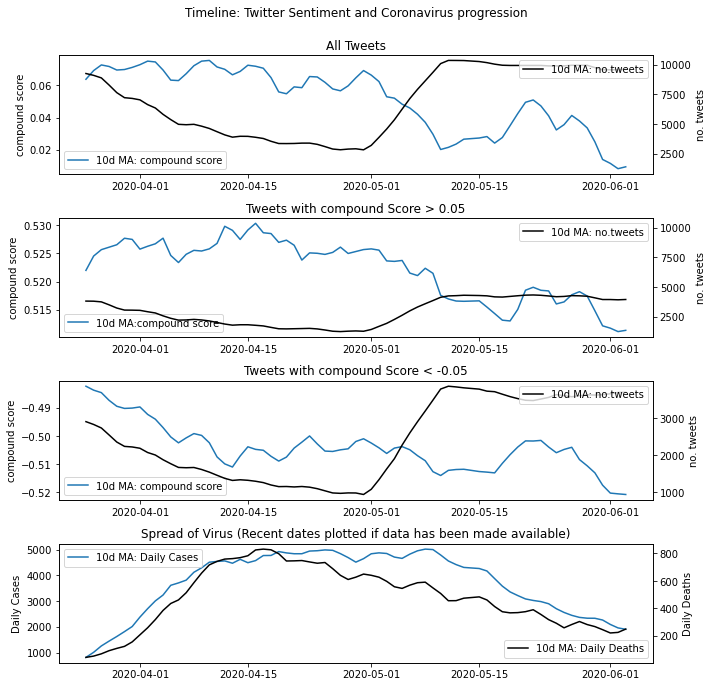

In [4]:
'''Group Sentiment Data by Date and plot alongside no.cases'''

start_date = '2020-03-16' # Choose date to start plotting from
score = 'compound' # Choose sentiment metric
pos_threshold = 0.05 # Choose threshold for positive valence
neg_threshold = -0.05 # Choose threshold for negative valence
window = 10

'''Filter for valences to plot'''
tweets_pos_valence = tweets[(tweets['{}'.format(score)] > pos_threshold)]
tweets_neg_valence = tweets[(tweets['{}'.format(score)] < neg_threshold)]

'''Merge with no.cases data'''
tweets_pos_valence = tweets_pos_valence.set_index('date').groupby(tweets_pos_valence.set_index('date').index.date).agg({'{}'.format(score):['mean','count']})
tweets_neg_valence = tweets_neg_valence.set_index('date').groupby(tweets_neg_valence.set_index('date').index.date).agg({'{}'.format(score):['mean','count']})
tweets_all_valence = tweets.set_index('date').groupby(tweets.set_index('date').index.date).agg({'{}'.format(score):['mean','count']})

cases_plt = cases.set_index('DateVal')
cases_plt['DailyCases_shifted_1'] = cases_plt.DailyCases.shift(1)
cases_plt['DailyDeaths_shifted_1'] = cases_plt.DailyDeaths.shift(1)

tweets_pos_valence = pd.merge(tweets_pos_valence, cases_plt, how='left', left_index=True, right_index=True, suffixes=('',''))
tweets_neg_valence = pd.merge(tweets_neg_valence, cases_plt, how='left', left_index=True, right_index=True, suffixes=('',''))
tweets_all_valence = pd.merge(tweets_all_valence, cases_plt, how='left', left_index=True, right_index=True, suffixes=('',''))

'''Filter for dates to plot'''
tweets_pos_valence = tweets_pos_valence[tweets_pos_valence.index.date>=datetime.strptime('{}'.format(start_date),'%Y-%m-%d').date()]
tweets_neg_valence = tweets_neg_valence[tweets_neg_valence.index.date>=datetime.strptime('{}'.format(start_date),'%Y-%m-%d').date()]
tweets_all_valence = tweets_all_valence[tweets_all_valence.index.date>=datetime.strptime('{}'.format(start_date),'%Y-%m-%d').date()]

'''Plot'''
fig, ax = plt.subplots(figsize=(10,10), sharex=True)
fig.suptitle('Timeline: Twitter Sentiment and Coronavirus progression')

# add subplots to current figure and assign them to variables
ax0 = plt.subplot(411)
ax1 = ax0.twinx()
ax2 = plt.subplot(412)
ax3 = ax2.twinx()
ax4 = plt.subplot(413)
ax5 = ax4.twinx()
ax6 = plt.subplot(414)
ax7 = ax6.twinx()

# share y-axes for no.tweets, and share x-axes for all plots to align dates:
ax1.get_shared_y_axes().join(ax1, ax3)
ax1.get_shared_x_axes().join(ax1, ax3, ax5, ax7)

# Plot data on their respective axes:
ax0.plot(tweets_all_valence[('{}'.format(score),'mean')].rolling(window).mean(),
         label='{}d MA: {} score'.format(window, score))
ax0.set_ylabel('{} score'.format(score))
ax0.legend(loc='lower left')
ax0.set_title('All Tweets')

ax1.plot(tweets_all_valence[('{}'.format(score),'count')].rolling(window).mean(),
         label='{}d MA: no.tweets'.format(window), c='k')
ax1.set_ylabel('no. tweets')
ax1.legend(loc='upper right')

ax2.plot(tweets_pos_valence[('{}'.format(score),'mean')].rolling(window).mean(),
         label='{}d MA:{} score'.format(window, score))
ax2.set_ylabel('{} score'.format(score))
ax2.legend(loc='lower left')
ax2.set_title('Tweets with {} Score > {}'.format(score,pos_threshold))

ax3.plot(tweets_pos_valence[('{}'.format(score),'count')].rolling(window).mean(),
         label='{}d MA: no.tweets'.format(window), c='k')
ax3.set_ylabel('no. tweets')
ax3.legend(loc='upper right')

ax4.plot(tweets_neg_valence[('{}'.format(score),'mean')].rolling(window).mean(),
         label='{}d MA: {} score'.format(window, score))
ax4.set_ylabel('{} score'.format(score))
ax4.legend(loc='lower left')
ax4.set_title('Tweets with {} Score < {}'.format(score,neg_threshold))

ax5.plot(tweets_neg_valence[('{}'.format(score),'count')].rolling(window).mean(),
         label='{}d MA: no.tweets'.format(window), c='k')
ax5.set_ylabel('no. tweets')
ax5.legend(loc='upper right')

ax6.plot(tweets_neg_valence['DailyCases'].rolling(window).mean(),
         label='{}d MA: Daily Cases'.format(window))
ax6.set_ylabel('Daily Cases')
ax6.legend(loc='upper left')
ax6.set_title('Spread of Virus (Recent dates plotted if data has been made available)')

ax7.plot(tweets_neg_valence['DailyDeaths'].rolling(window).mean(),
         label='{}d MA: Daily Deaths'.format(window), c='k')
ax7.set_ylabel('Daily Deaths')
ax7.set_ylabel('Daily Deaths')
ax7.legend(loc='lower right')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig('./images/sent_vs_cases.png');

### Correlations: Sentiment vs Disease Progression
Summary:
- The Correlation matrix below suggests an increase in no.tweets and also higher negative valence as the cases and deaths increased.
- Introducing a 1-day lag increases this correlation, suggesting a lagged effect of the effect on sentiment of the disease
- We also visualise this through scatter plots further below

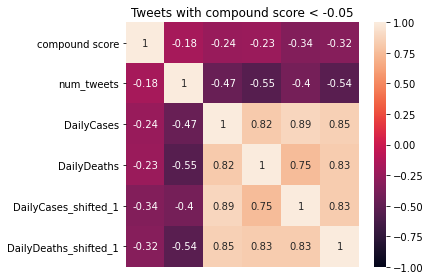

In [5]:
heatmap_df = tweets_neg_valence.rename(columns={('compound','mean'):'compound score',('compound','count'):'num_tweets'})

fig, ax = plt.subplots()
sns.heatmap(heatmap_df.iloc[1:,[0,1,2,4,12,13]].corr(), vmin=-1, vmax=1, annot=True, xticklabels=False)
plt.title('Tweets with compound score < -0.05')
plt.tight_layout()
fig.savefig('./images/heatmap.png');

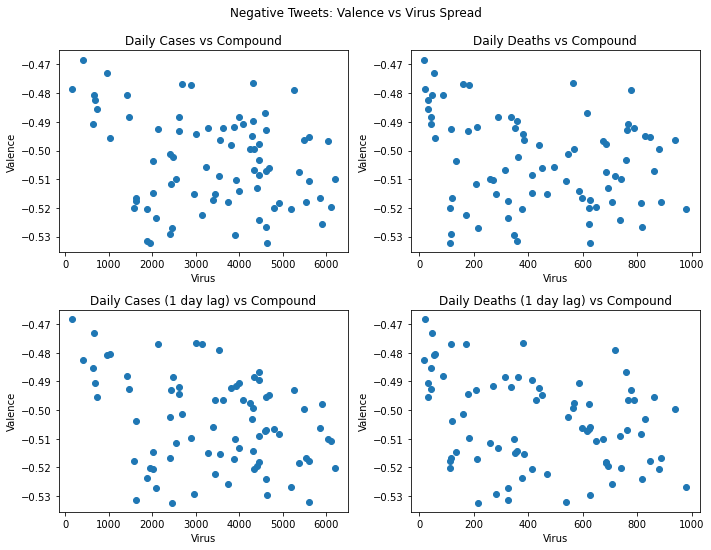

In [6]:
'''Scatter Plots of Valence of Negative Tweets vs Cases and Deaths'''

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
fig.suptitle('Negative Tweets: Valence vs Virus Spread')

ax[0,0].scatter(tweets_neg_valence['DailyCases'],tweets_neg_valence[('compound','mean')])
ax[0,0].set_xlabel('Virus')
ax[0,0].set_ylabel('Valence')
ax[0,0].set_title('Daily Cases vs Compound')

ax[0,1].scatter(tweets_neg_valence['DailyDeaths'],tweets_neg_valence[('compound','mean')])
ax[0,1].set_xlabel('Virus')
ax[0,1].set_ylabel('Valence')
ax[0,1].set_title('Daily Deaths vs Compound')

ax[1,0].scatter(tweets_neg_valence.iloc[1:,-2],tweets_neg_valence.iloc[1:,0])
ax[1,0].set_xlabel('Virus')
ax[1,0].set_ylabel('Valence')
ax[1,0].set_title('Daily Cases (1 day lag) vs Compound')

ax[1,1].scatter(tweets_neg_valence.iloc[1:,-1],tweets_neg_valence.iloc[1:,0])
ax[1,1].set_xlabel('Virus')
ax[1,1].set_ylabel('Valence')
ax[1,1].set_title('Daily Deaths (1 day lag) vs Compound')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]);

The correlation was observed over time to be quite strongly showing a deterioration in sentiment with an increase in no. cases / deaths, however in the recent period, this strong correlation has broken down, with sentiment remaining range-bound as virus numbers decreased, we plot this:

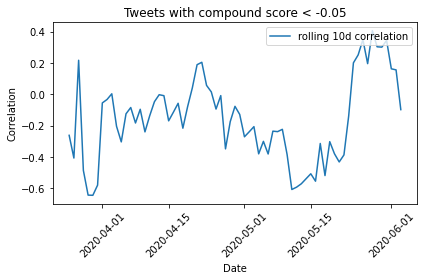

In [7]:
df = heatmap_df
window = 10
correl = df.iloc[:,[0,4]].rolling(window).corr()

plt.plot(df.index,
         correl[np.in1d(correl.index.get_level_values(1), 'compound score')]['DailyDeaths'],
         label='rolling {}d correlation'.format(window))
plt.title('Neg Sentiment vs Daily Deaths')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.title('Tweets with compound score < -0.05')
plt.legend(loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('./images/correlationhistory.png');

It appears there's some correlation between valence and the disease's progression given the heatmap above which suggested a ~50% correlation.

##### Conclusion
- Looking again at the trend in virus progression, vs the trend in overall negative sentiment: it's clear to see that despite large swings in the number of cases and deaths, the average valence in negative tweets was relatively unchanged.
- This confirms previous findings that as you zoom out, and include more tweets in your dataset, the sentiment tends to revert to mean.
- It's better advised to use sentiment analysis to compare distribution of sentiment for different subsets of the population of the tweets, as we turn to below in Thematic Sentiment

# PART 2: HYPOTHESIS TESTING
Checking my data for statistical significance in the difference in sentiment for different entities

### Themes of immediate interest
- First I turn to specific entities of interest, namely the Government and the NHS.
- I used spaCy's EntityRulers to recognize custom entities of my choosing to retrieve these specific entities for me (above, in the spacy_text_processor function)
- I am then able to find those tweets referencing each of these topics, and conduct comparative sentiment analysis

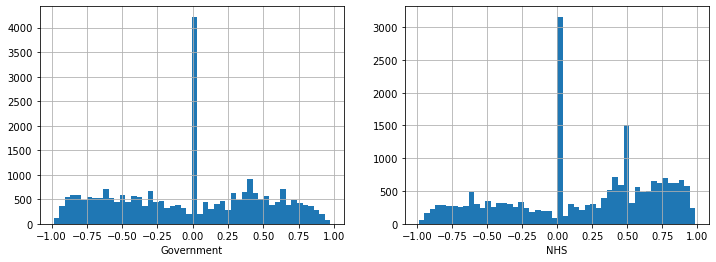

In [8]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
tweets[tweets.topical_orgs=='government']['compound'].hist(ax=ax[0], bins=50)
tweets[tweets.topical_orgs=='nhs']['compound'].hist(ax=ax[1], bins=50)
ax[0].set_xlabel('Government')
ax[1].set_xlabel('NHS')
plt.savefig('./images/govnhs_histogram.png');

In [482]:
print('Avg Gov sentiment',np.mean(tweets[tweets.topical_orgs == 'government']['compound']))
print('Avg NHS sentiment',np.mean(tweets[tweets.topical_orgs == 'nhs']['compound']))

Avg Gov sentiment -0.036404310344827585
Avg NHS sentiment 0.17067980952380954


Interesting there is a 2nd spike for NHS at ~0.5 compound score, but this is due to different tweets all say THANK YOU, not from duplicates, so these are fine to keep

In [475]:
tweets[(tweets.topical_orgs=='nhs')&(tweets.compound>0.4)&(tweets.compound<0.5)]\
.sort_values('compound', ascending=False).head(20)

,username,tweet_id,date,favorites,hashtags,mentions,retweets,replies,text,topical_persons,topical_orgs,persons,orgs,propn,compound,neg,neu,pos
224484,EraBalentogo,1252603629149790208,2020-04-21 14:22:32+00:00,2,#NHS #COVID19 #TeamKings,@TurnipsBorough @FuelFrontline,1,0,A big THANK YOU to @TurnipsBorough for all the fruit &amp; veg and also for all the meals @FuelFrontline. #NHS #COVID19 #TeamKings.,NaN,nhs,NaN,NaN,amp veg NHS TeamKings,0.4995,0.000,0.867,0.133
250473,MainStreetAppar,1255937967975215104,2020-04-30 19:12:00+00:00,1,#ClapForCarers #ClapForNHS #NHS #KeyWorkers #Lockdown #DisneylandParis #DisneyWorld #DisneyWorld #Disney #TomorrowWillBeAGoodDay #ColonelTomMoore #Coronavirus,NaN,1,0,THANK YOU #ClapForCarers #ClapForNHS #NHS #KeyWorkers #Lockdown #DisneylandParis #DisneyWorld #Disney #TomorrowWillBeAGoodDay #ColonelTomMoore #Coronavirus,NaN,nhs,Coronavirus,NaN,NHS # KeyWorkers # Lockdown # DisneylandParis # DisneyWorld # Disney ColonelTomMoore Coronavirus,0.4995,0.000,0.788,0.212
197369,T21SweetBoyz,1249735995085303809,2020-04-13 16:27:34+00:00,2,#NHS #NHSWorkers #LondonNHS #FrontlineNHS #MedicalTeam #StayAtHome #StayAtHome #coronavirus,@Ray_Electronica,2,0,A BIG THANK YOU TO hollandandbarret & @ray_electronica FOR TODAY'S EASTER EGG DONATION @ST GEORGES HOSPITAL #NHS #NHSWorkers #LondonNHS #FrontlineNHS #MedicalTeam #StayAtHome #coronavirus… https://www.instagram.com/p/B-7X_hmnEM6/?igshid=1pt44qnn9nbcd,NaN,nhs,NaN,NaN,hollandandbarret @ray_electronica TODAY GEORGES HOSPITAL NHS MedicalTeam StayAtHome https://www.instagram.com/p/B-7X_hmnEM6/?igshid=1pt44qnn9nbcd,0.4995,0.000,0.877,0.123
153722,SusanRitah,1245795700643938307,2020-04-02 19:30:15+00:00,0,#thankyounhs #clappingfornhs #covid19 #weareinittogether #stayathome #stayathome #bandanavixenv,NaN,0,0,"THANK YOU NHS biglovenhs #thankyounhs #clappingfornhs #covid19 #weareinittogether #stayathome #bandanavixenv @Surbiton, London https://www.instagram.com/p/B-fXptfHX547mYQENV7qhiMNzIqJz6sSk4dHeI0/?igshid=140164if070ql",NaN,nhs,NaN,NaN,NHS @Surbiton London,0.4995,0.000,0.788,0.212
153738,SusanRitah,1245796412551581697,2020-04-02 19:33:05+00:00,0,#thankyounhs #clappingfornhs #covid19 #weareinittogether #stayathome #stayathome #bandanavixenv,NaN,0,0,"THANK YOU NHS biglovenhs #thankyounhs #clappingfornhs #covid19 #weareinittogether #stayathome #bandanavixenv @Surbiton, London https://www.instagram.com/p/B-fXptfHX547mYQENV7qhiMNzIqJz6sSk4dHeI0/?igshid=5am4vsz5x9b6",NaN,nhs,NaN,NaN,NHS @Surbiton London,0.4995,0.000,0.788,0.212
178070,T21SweetBoyz,1247858257831636992,2020-04-08 12:06:07+00:00,0,#NHS #NHSWorkers #LondonNHS #FrontlineNHS #MedicalTeam #StayAtHome #StayAtHome #coronavirus #HelpThoseWhoHelpUs,NaN,0,0,A BIG THANK YOU TO zak_hobcafe FROM @misterasbalham FOR TODAY'S LUNCH @ST GEORGES HOSPITAL #NHS #NHSWorkers #LondonNHS #FrontlineNHS #MedicalTeam #StayAtHome #coronavirus #HelpThoseWhoHelpUs… https://www.instagram.com/p/B-uCGLCH2rm/?igshid=14ojey90jqxnv,NaN,nhs,NaN,NaN,zak_hobcafe TODAY 'S LUNCH @ST GEORGES NHS MedicalTeam StayAtHome #,0.4995,0.000,0.872,0.128
111593,JayKamiraz,1243271153663303681,2020-03-26 20:18:36+00:00,6,#clapforNHS #ClapForCarers #nhs #thankyounhs #stayhome #coronavirus #covid19 #stayathomesaveslives #ournhs,@NHSuk,1,0,THANK YOU @NHSuk #clapforNHS #ClapForCarers #nhs #thankyounhs #stayhome #coronavirus #covid19 #stayathomesaveslives #ournhs,NaN,nhs,NaN,NaN,coronavirus # covid19 #,0.4995,0.000,0.773,0.227
304461,graffitimuralma,1258048510374666240,2020-05-06 14:58:32+00:00,9,#nhs #mural #graffitimuralmasters #COVID19,NaN,1,0,MASSIVE SHOUT OUT TO THE NHS AND ALL THE KEY WORKERS. WE THANK YOU. #nhs #mural #graffitimuralmasters #COVID19 – at Tesco Express,NaN,nhs,NaN,Tesco Express,NHS WORKERS nhs # Tesco Express,0.4995,0.000,0.867,0.133
226838,London_Chazz,1252883735898402816,2020-04-22 08:55:34+00:00,3,#NHS #COVID #PPE #Turkiye #corona #coronavirus,@RTErdogan,1,0,Coronavirus: RAF plane lands in UK with PPE from Turkey......... THANK YOU TURKEY .Yo

The NHS distribution is skewed to the right, so we hypothesise:

#### Hypothesis 1:
Null Hypothesis is that sentiment for the NHS and the Government was the same

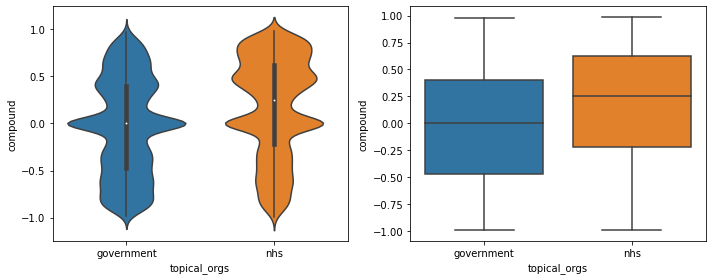

In [9]:
fig, ax = plt.subplots(ncols=2, figsize=(10,4))
sns.violinplot(y='compound', x='topical_orgs', data=tweets[tweets.topical_orgs != ''], ax=ax[0])
sns.boxplot(y='compound', x='topical_orgs', data=tweets[tweets.topical_orgs != ''], ax=ax[1])
plt.tight_layout()
plt.savefig('./images/govnhs_boxplot.png');

We will compare the sample means using a t-test, it assumed standard deviation for both samples is the same:
- the IQRs in the boxplot are roughly the same size for both distributions, which points to this fact
- we also confirm this here:

In [479]:
print('StDev of Gov sentiment',np.std(tweets[tweets.topical_orgs == 'government']['compound']))
print('StDev of NHS sentiment',np.std(tweets[tweets.topical_orgs == 'nhs']['compound']))

StDev of Gov sentiment 0.5088439608473287
StDev of NHS sentiment 0.5270063682595049


Running SciPy's t-test:
- Note: had sample standard deviations not been equal, then set equal_var = False to use Welch's t-statistic (ie. out standard error is calculated differently because we can't pool our two distributions together)

In [483]:
stats.ttest_ind(tweets[tweets.topical_orgs == 'nhs']['compound'],
                tweets[tweets.topical_orgs == 'government']['compound'], equal_var=True)

Ttest_indResult(statistic=43.62708002444751, pvalue=0.0)

Alternatively could have run Statsmodel API's ztest:

In [101]:
sm.stats.ztest(tweets[tweets.topical_orgs == 'government']['compound'],
               tweets[tweets.topical_orgs == 'nhs']['compound'])

(-38.63666646209801, 0.0)

- So p-value is essentially 0, which says that if null hypothesis is assumed to be true, then there is 0 (or very small) chance of observing what we've just observed as the alternate hypothesis.
- How small the p-value is, assuming proper statistical process, is how much confidence we have in rejecting the null hypothesis. Because we're saying there's no chance we'd have seen this alternate hypothesis (so far into the tail as it was) if the null was true.

We can construct a 95% confidence interval for our difference in sample means to further confirm this:

In [44]:
p_gov = np.mean(tweets[tweets.topical_orgs == 'government']['compound'])
p_nhs = np.mean(tweets[tweets.topical_orgs == 'nhs']['compound'])

num_gov = len(tweets[tweets.topical_orgs == 'government'])
num_nhs = len(tweets[tweets.topical_orgs == 'nhs'])

The s.e. for each population (as we're comparing MEANS here) is simply: $\sigma / \sqrt{n}$

In [45]:
se_gov = np.std(tweets[tweets.topical_orgs == 'government']['compound']) / np.sqrt(num_gov)
se_nhs = np.std(tweets[tweets.topical_orgs == 'nhs']['compound']) / np.sqrt(num_nhs)

Alternatively, statsmodels has a function s.e. of the mean of a distribution:

In [55]:
print('Gov sentiment s.e.', stats.sem(tweets[tweets.topical_orgs == 'government']['compound'], axis=None))
print('NHS sentiment s.e.', stats.sem(tweets[tweets.topical_orgs == 'nhs']['compound'], axis=None))

Gov sentiment s.e. 0.003658893871065916
NHS sentiment s.e. 0.0039043862431747903


With the standard error for both populations to be used in CI formula below: $SE = \sqrt{(SE_{\ 1})^2 + (SE_{\ 2})^2}$

In [46]:
se_diff = np.sqrt(se_gov**2 + se_nhs**2)

In [43]:
diff = p_gov - p_nhs
lcb = diff - (1.96 * se_diff)
ucb = diff + (1.96 * se_diff)
(lcb, ucb)

(-0.21567477509080404, -0.1946999608361962)

- So we can say are 95% confident that average sentiment for government is lower than for the NHS
- We can also plot how this CI varied over time, ie. one CI per day in the observation period:

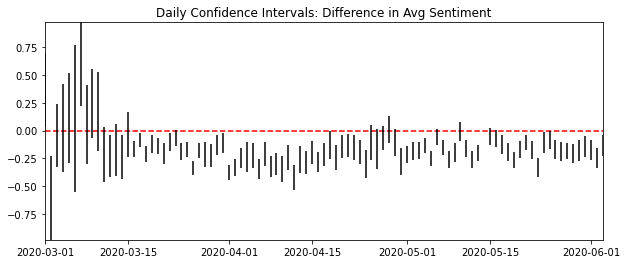

In [10]:
lower_bounds = []
upper_bounds = []

for day in tweets.date.dt.date.unique():
    sample = tweets[tweets.date.dt.date==day]
    
    # means:
    mean_gov = np.mean(sample[sample.topical_orgs == 'government']['compound'])
    mean_nhs = np.mean(sample[sample.topical_orgs == 'nhs']['compound'])

    # n_samples:
    num_gov = len(sample[sample.topical_orgs == 'government'])
    num_nhs = len(sample[sample.topical_orgs == 'nhs'])
    
    # standard errors:
    se_gov = np.std(sample[sample.topical_orgs == 'government']['compound']) / np.sqrt(num_gov)
    se_nhs = np.std(sample[sample.topical_orgs == 'nhs']['compound']) / np.sqrt(num_nhs)
    se_diff = np.sqrt(se_gov**2 + se_nhs**2)
    
    diff = mean_gov - mean_nhs
    lb = diff - (1.96 * se_diff)
    ub = diff + (1.96 * se_diff)
    lower_bounds.append(lb)
    upper_bounds.append(ub)
    
plt.figure(figsize=(10,4))
plt.title('Daily Confidence Intervals: Difference in Avg Sentiment')
plt.xlim(tweets.date.dt.date.unique().min(), tweets.date.dt.date.unique().max())
plt.ylim(min(lower_bounds), max(upper_bounds))
plt.hlines(0, tweets.date.dt.date.unique().min(), tweets.date.dt.date.unique().max(), colors='r', linestyles='dashed')
for (day, lb, ub) in list(zip(tweets.date.dt.date.unique(), lower_bounds, upper_bounds)):
    plt.vlines(day, lb, ub)
plt.savefig('./images/govnhs_confidenceintervals.png');

- At the start of the observation period, there were relatively few tweets made per day, these small daily sample sizes led to increased standard errors and therefore larger CIs, as time progressed and daily sample sizes increased, CIs narrowed and were mainly completely below the dashed red zero line. Which indicates a 95% confidence that average sentiment towards the government < for the NHS.
    - STATISTICAL POWER: this increase in number of samples over time, and the narrowing of the CIs points to increased power of the test, ie. an increased ability to distinguish between two distributions and therefore a reduced chance of Type II error.
- The advantage of plotting the daily CIs, is that there is confidence in rejecting the null hypothesis even though March and May had large daily sample sizes compared to April. Because despite this, the CIs are generally wholly in negative territory

#### Verdict
- The very low p-value gives us good confidence in Rejecting the Null Hypothesis.
- Judging from the plots, and mean sentiments, tweets regarding the NHS were more positive than for the Government.

#### Explanation

Looking at the below distplot, there were both more positive tweets and fewer negative tweets for the NHS vs the Government:

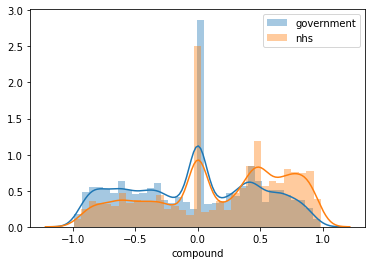

In [11]:
sns.distplot(tweets[tweets.topical_orgs == 'government']['compound'], label='government')
sns.distplot(tweets[tweets.topical_orgs == 'nhs']['compound'], label='nhs')
plt.legend()
plt.savefig('./images/govnhs_distplot.png');

If this is statistically significant, this would be a good explanation. We check for this by constructing a confidence interval for the difference between the two population proportions (% pos tweets, and % neg tweets)

1. Positive tweets:

As you will see here: as the population parameter we are comparing isn't a mean this time, the standard error formula changes from:
<br>
<br>
$$\sigma / \sqrt{n}$$
to:
<br>
$$\sqrt{p(1-p) / n}$$

In [27]:
p_gov = len(tweets[(tweets.topical_orgs == 'government') & (tweets.compound > 0.05)]) / len(tweets[tweets.topical_orgs == 'government'])
num_gov = len(tweets[tweets.topical_orgs == 'government'])
se_gov = np.sqrt(p_gov * (1-p_gov) / num_gov)

print(p_gov, num_gov, se_gov)

0.40296296296296297 18900 0.0035678147791856117


In [28]:
p_nhs = len(tweets[(tweets.topical_orgs == 'nhs') & (tweets.compound > 0.05)]) / len(tweets[tweets.topical_orgs == 'nhs'])
num_nhs = len(tweets[tweets.topical_orgs == 'nhs'])
se_nhs = np.sqrt(p_nhs * (1-p_nhs) / num_nhs)

print(p_nhs, num_nhs, se_nhs)

0.5657938533229779 18026 0.0036917085952754484


We have the s.e. for each population (gov vs nhs), now the s.e. of the difference of two population parameters is:
$SE = \sqrt{(SE_{\ 1})^2 + (SE_{\ 2})^2}$
<br>
which will always be greater than the individual populations, it's a combination of them both

In [34]:
se_diff = np.sqrt(se_gov**2 + se_nhs**2)
se_diff

0.005134005712015317

We now have what we need to calculate the 95% confidence interval for the difference in population proportion of positive tweets:

In [35]:
diff = p_gov - p_nhs
lcb = diff - (1.96 * se_diff)
ucb = diff + (1.96 * se_diff)
(lcb, ucb)

(-0.172893541555565, -0.15276823916446494)

We can see with 95% confidence that tweets re. Government had a lower proportion of positive than tweets re: NHS.

2. Negative Tweets

In [131]:
p_gov = len(tweets[(tweets.topical_orgs == 'government') & (tweets.compound < -0.05)]) / len(tweets[tweets.topical_orgs == 'government'])
p_nhs = len(tweets[(tweets.topical_orgs == 'nhs') & (tweets.compound < -0.05)]) / len(tweets[tweets.topical_orgs == 'nhs'])

Then calculating the confidence interval for the difference in proportion of negative tweets

In [37]:
diff = p_gov - p_nhs
lcb = diff - (1.96 * se_diff)
ucb = diff + (1.96 * se_diff)
(lcb, ucb)

(0.12724484761422325, 0.1473701500053233)

We can also say with 95% confidence that tweets re. Government had a higher proportion of negative tweets than tweets re: NHS.
- This analysis asked what the 95% CI was for difference in ratio_pos and ratio_neg tweets, we could have run a 'difference of two proportions' test which is nothing more than solving for the t-statistic above, to reject / accept H0 = 0.
- For the difference in two proportions:
    - $H_0: \hat{p} = 0$
    - $H_A: \hat{p} = p_{gov} - p_{nhs}$
    - $s.e.(\hat{p}) = \sqrt{\hat{p}(1-\hat{p})(\frac{1}{n_{gov}} + \frac{1}{n_{nhs}})}$
    - And as always the we plug the above into: $t-statistic = \frac{H_A - H_0}{s.e.(\hat{p})}$

1. Postitive Tweets
    - Note p_hat here is nhs-gov, not gov-nhs as indicated above to ensure a positive number that can be used in the s.e. formula

In [508]:
pos_threshold = 0.05

p_gov = len(tweets[(tweets.topical_orgs == 'government') & (tweets.compound > pos_threshold)]) / len(tweets[tweets.topical_orgs == 'government'])
p_nhs = len(tweets[(tweets.topical_orgs == 'nhs') & (tweets.compound > pos_threshold)]) / len(tweets[tweets.topical_orgs == 'nhs'])
p_hat = p_nhs - p_gov
print('Difference in (Positive Tweets / Total Tweets):', p_hat)

Difference in (Positive Tweets / Total Tweets) 0.15881778668707092


In [504]:
H_0 = 0

H_A = p_hat

num_gov = len(tweets[tweets.topical_orgs == 'government'])
num_nhs = len(tweets[tweets.topical_orgs == 'nhs'])

se = np.sqrt(p_hat*(1-p_hat)*((1/num_gov)+(1/num_nhs)))

t_stat = (p_hat - 0) / se
p_value = 2*stats.norm.cdf(-np.abs(t_stat))
print('t-statistic', t_stat, 'p-value', p_value)

t-statistic 47.33409611769171 p-value 0.0


This says that $H_{A}$ is 43 standard errors away from the mean, so we can very safely reject the null hypothesis

2. Negative Tweets:
    - Here it's gov-nhs for same reason:

In [509]:
neg_threshold = -0.05

p_gov = len(tweets[(tweets.topical_orgs == 'government') & (tweets.compound < neg_threshold)]) / len(tweets[tweets.topical_orgs == 'government'])
p_nhs = len(tweets[(tweets.topical_orgs == 'nhs') & (tweets.compound < neg_threshold)]) / len(tweets[tweets.topical_orgs == 'nhs'])
p_hat = p_gov - p_nhs
print('Difference in (Negative Tweets / Total Tweets):', p_hat)

Difference in (Negative Tweets / Total Tweets): 0.14177193931000753


In [111]:
H_0 = 0

H_A = p_hat

num_gov = len(tweets[tweets.topical_orgs == 'government'])
num_nhs = len(tweets[tweets.topical_orgs == 'nhs'])

se = np.sqrt(p_hat*(1-p_hat)*((1/num_gov)+(1/num_nhs)))

t_stat = (p_hat - 0) / se
p_value = 2*dist.norm.cdf(-np.abs(t_stat))
print('t-statistic', t_stat, 'p-value', p_value)

t-statistic 38.561197004624 p-value 0.0


This says that $H_{A}$ is 39 standard errors away from the mean, so we can very safely reject the null hypothesis

- We could have also tested these pos / neg ratios another more concise way, using the Chi-Squared test...

#### Hypothesis 2:
Null Hypothesis is proportions of positive and negative tweets are the same for Gov and NHS.
- A Chi-Squared ($\chi^2$) test looks at a flat table of the values per cell, and asks if each the ratio of the value of each cell to it's total is the same across all columns. Very simple:
    - First, create pd.crosstab of required rows, and columns to pivot by
    - Then feed this crosstab into scipy's chisquared test

In [522]:
def labeller(sentiment_col, abs_threshold=0.05):
    if sentiment_col < -abs_threshold:
        return 'NEG'
    elif sentiment_col > abs_threshold:
        return 'POS'
    else:
        return 'NEU'

chi_tweets_df = tweets[['topical_orgs','compound']].dropna()
chi_tweets_df['category'] = chi_tweets_df.compound.apply(labeller)
chi_tweets_df.head()

,topical_orgs,compound,category
10,government,-0.1680,NEG
11,government,-0.7664,NEG
33,nhs,-0.4767,NEG
39,nhs,-0.7351,NEG
62,government,0.3612,POS


In [524]:
pd.crosstab(chi_tweets_df.topical_orgs, chi_tweets_df.category)

category,NEG,NEU,POS
topical_orgs,,,
government,11445,4481,10522
nhs,6263,3280,11982


We have at least 5 observations in each cell above, so we can use `chi2_contingency` but if any cell < 5 observations then Fisher's Exact Z-Test would be needed to account for higher variability in the sample statistic, and more conservative tails

In [54]:
stats.chi2_contingency(crosstab)

(1047.7937788707934,
 2.981754146928481e-228,
 2,
 array([[6978.92922191, 3234.01294658, 9538.05783151],
        [6640.07077809, 3076.98705342, 9074.94216849]]))

Scipy's `chi2_contingency` function tests if the observed frequencies are the same as the expected ones. It returns

- the chi2 ($\chi^{2}$)-statistic
- the p-value
- the number of degrees of freedom
- the expected frequencies as calculated above

the chi2 ($\chi^{2}$)-statistic is calculated as:

$\chi^{2}-statistic = \sum{(x - \bar{x})^{2}}$

where:
- $x$ = each value in the crosstab
- $\bar{x}$ = expected value if no variation in sentiment based on org

#### Verdict

- We can clearly see that this test corroborates the finding that null hypothesis can be rejected
- Another question is: are the relatively more negative sentiment towards the Government vs the NHS consistent in the same tweeters, or is there a split between those who view the NHS positively and those who view Government positively?
    - We explore this through testing the difference in means for paired data: where data here will be paired by tweeter, and testing the difference in avg sentiment per user

#### Hypothesis 3:
At the user-level, the null hypothesis is that there is no difference in sentiment towards Gov vs NHS: (therefore the overall difference in sentiment found in the previous hypotheses is attributed to different Twitter accounts)

First we visualise the problem using pd.crosstab() to give a user-level table of Gov vs NHS tweets

In [13]:
crosstab = pd.crosstab(tweets.username, tweets.topical_orgs, tweets.compound, aggfunc='mean').dropna()
crosstab['diff'] = crosstab.apply(lambda x: x['government']-x['nhs'], axis=1)
crosstab.head()

topical_orgs,government,nhs,diff
username,,,
100pcLondoner,0.611500,-0.899200,1.510700
10DowningStreet,0.203109,0.437111,-0.234002
12no34rou,-0.137550,0.250000,-0.387550
1BritishPatriot,-0.584400,-0.347000,-0.237400
2wheelchick,0.905100,-0.812600,1.717700


One assumption of this test is that the paired differences are normally distributed, although with a very high number of samples we can leverage the CLT, we will check the distribution here by plotting the distribution and Q-Q plots nonetheless:

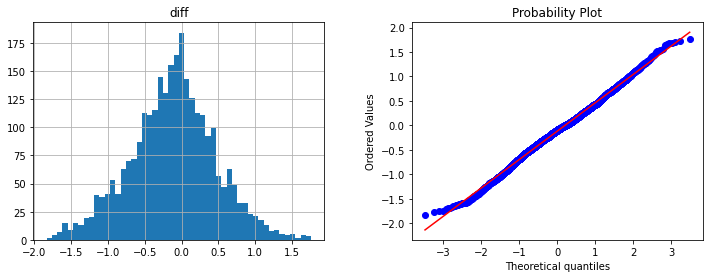

In [14]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
crosstab.hist('diff', bins=50, ax=ax[0])
stats.probplot(crosstab['diff'], plot=pylab)
pylab.show()
fig.savefig('./images/pairedmeans_normality.png');

- From these plots we can assume normality roughly holds here (even if it didn't CLT would save us)
- So, as always:
    - $H_0: 0$
    - $H_A: \bar{x_d} =$ mean of the paired differences
    - $s.e.(\bar{x_d}) = \frac{s_d}{\sqrt{n}}$
    - And as always the we plug the above into: $t-statistic = \frac{H_A - H_0}{s.e.(\bar{x_d})}$
    
So the only difference when looking at paired means, is that we are looking at the mean(paired diffs) and std(paired diffs), and plugging into same Mean Hypthosis Testing formula

In [112]:
xd_bar = np.mean(crosstab['diff'])
se_xd_bar = np.std(crosstab['diff']) / np.sqrt(len(crosstab))

t_stat = (xd_bar - 0) / se_xd_bar
p_value = 2*dist.norm.cdf(-np.abs(t_stat))
print('t-statistic', t_stat, 'p-value', p_value)

t-statistic -9.038003484082056 p-value 1.5955928856004563e-19


Alternatively use the ttest_rel scipy function designed for paired testing

In [107]:
stats.ttest_rel(crosstab.government, crosstab.nhs)

Ttest_relResult(statistic=-9.035954747008454, pvalue=3.4616270088977246e-19)

- We can also test this under non-normality assumptions, ie. if we were not so confident that distribution of paired-diffs was normal, and if we couldn't use CLT...

##### Wilcoxon Signed-Rank test:
- ... then we'd use the Wilcoxon Signed-Rank test, which looks at whether the median of the distribution of differences is = 0 (null == 0 in the case of a 2-sided Wilcoxon). This is the non-parametric analogue of the above t-test

In [123]:
stats.wilcoxon(crosstab.government, crosstab.nhs)

WilcoxonResult(statistic=934184.0, pvalue=1.2233021976129815e-18)

p-values in all cases, are approaching 0

#### Verdict

On this basis, we reject the null hypothesis and can say that even at an account level, there was generally more positive sentiment towards the NHS than towards the Government

### Visualise sentiment

Can we visualise what type of sentiment people had for the Government vs the NHS? Let's look at the words that were being used to better understand how the public described each entity:

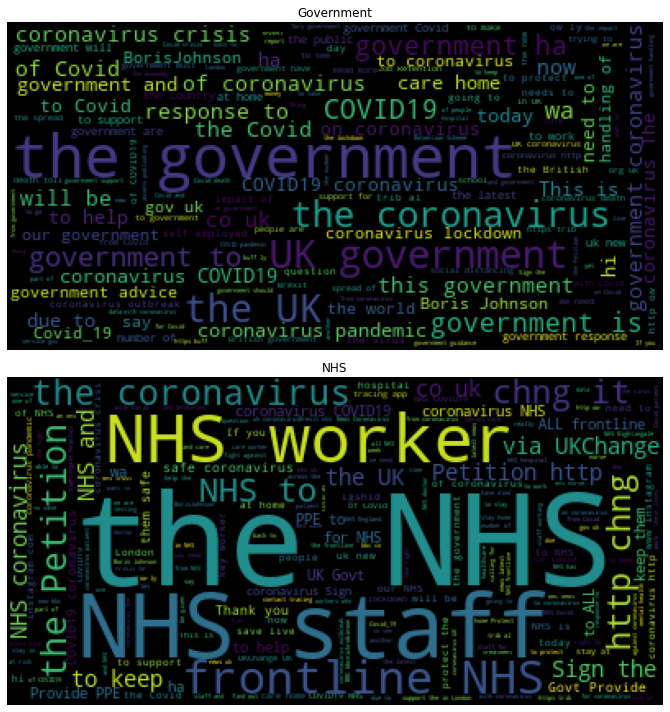

In [15]:
gov_text = " ".join(tweet for tweet in tweets.text[tweets.topical_orgs=='government'])
nhs_text = " ".join(tweet for tweet in tweets.text[tweets.topical_orgs=='nhs'])

stopwords = set(STOPWORDS)
stopwords.update(['http', 'https', 'www', 'amp', 'ly', 'bit'])

gov_wordcloud = WordCloud(stopwords=stopwords).generate(gov_text)
nhs_wordcloud = WordCloud(stopwords=stopwords).generate(nhs_text)

fig, ax = plt.subplots(nrows=2, figsize=(10,10))
ax[0].imshow(gov_wordcloud)
ax[0].set_title('Government')
ax[0].axis('off')
ax[1].imshow(nhs_wordcloud)
ax[1].set_title('NHS')
ax[1].axis('off')
plt.tight_layout()
plt.savefig('./images/wordcloud_nhsgov.png');

It's not entirely clear to see what the public thought of the Government vs the NHS, as these wordclouds are dominated by oft-used words that were neutral in sentiment.
- I will take these corpora of words and pass them through my vader scorer
- Then filter for the most emotive words (positive or negative), and visualise only those words in wordclouds.

In [16]:
gov_text_df, gov_sentiment = emotive_filter(gov_text)
nhs_text_df, nhs_sentiment = emotive_filter(nhs_text)

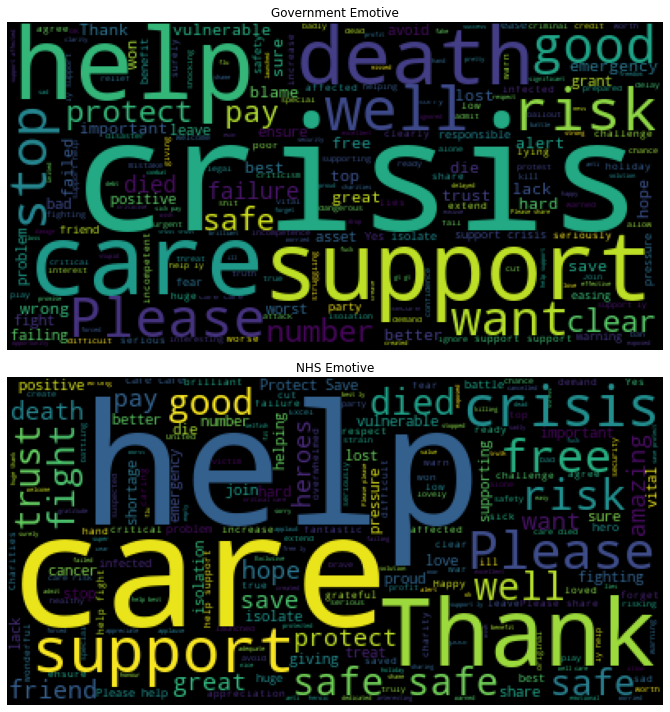

In [17]:
def vader_scorer(df):
    analyzer = SentimentIntensityAnalyzer()
    vader_scores = df.loc[:,'text'].map(analyzer.polarity_scores)

    dvec = DictVectorizer()
    vader_scores = dvec.fit_transform(vader_scores)
    
    vader_scores = pd.DataFrame(vader_scores.toarray(),columns=dvec.feature_names_)
    return vader_scores
    
gov_text_df, gov_sentiment = emotive_filter(gov_text)
nhs_text_df, nhs_sentiment = emotive_filter(nhs_text)

pos_threshold = 0.05
neg_threshold = -0.05

gov_emotive_words = gov_text_df[(gov_sentiment.compound < neg_threshold) | (gov_sentiment.compound > pos_threshold)]
nhs_emotive_words = nhs_text_df[(nhs_sentiment.compound < neg_threshold) | (nhs_sentiment.compound > pos_threshold)]

gov_emotive_wordcloud = WordCloud(stopwords=stopwords).generate(gov_emotive_words.to_string())
nhs_emotive_wordcloud = WordCloud(stopwords=stopwords).generate(nhs_emotive_words.to_string())

fig, ax = plt.subplots(nrows=2, figsize=(10,10))
ax[0].imshow(gov_emotive_wordcloud)
ax[0].set_title('Government Emotive')
ax[0].axis('off')
ax[1].imshow(nhs_emotive_wordcloud)
ax[1].set_title('NHS Emotive')
ax[1].axis('off')
plt.tight_layout()
plt.savefig('./images/wordcloud_nhsgov_emotive.png');

These wordclouds give a clearer picture of why the NHS was seen more positively than the Government:
- Gov: tweeters reference the Government when highlighting perceived failures, rarely is there positive mention of government work.
    - crisis, failure, died, die, vulnerable, stop, failed, seriously, lack, emergency, hard, warning, failing

- NHS: tweets generally reference NHS as heroes for the support and care they give in such trying circumstances.
    - thank, care, support, well, help, safe, good, protect, love, helping, hope, friend, heroes, proud, great
    
It's interesting therefore that despite ostensibly working towards a common goal, the public it seems perhaps see the NHS as fighting it's battles better than the government has.

In [18]:
nhs_tweets = tweets[tweets.topical_orgs=='nhs']
nhs_grouped = nhs_tweets.groupby(nhs_tweets.set_index('date').index.date).agg({'compound':['mean','count']})
nhs_tweets_case = pd.merge(nhs_grouped, cases_plt, how='left', left_index=True, right_index=True, suffixes=('',''))

/Users/Noah/anaconda3/envs/nlp_architect/lib/python3.7/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


/Users/Noah/anaconda3/envs/nlp_architect/lib/python3.7/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


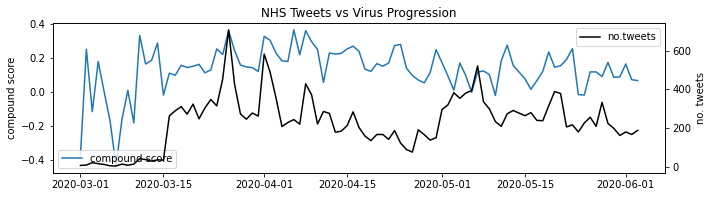

In [19]:
nhs_tweets = tweets[tweets.topical_orgs=='nhs']
nhs_grouped = nhs_tweets.groupby(nhs_tweets.set_index('date').index.date).agg({'compound':['mean','count']})
nhs_tweets_case = pd.merge(nhs_grouped, cases_plt, how='left', left_index=True, right_index=True, suffixes=('',''))

fig, ax = plt.subplots(figsize=(10,10), sharex=True)

ax0 = plt.subplot(411)
ax1 = ax0.twinx()

ax0.plot(nhs_tweets_case[('compound','mean')], label='compound score')
ax0.set_ylabel('compound score')
ax0.legend(loc='lower left')
ax0.set_title('NHS Tweets vs Virus Progression')

ax1.plot(nhs_tweets_case[('compound','count')], label='no.tweets', c='k')
ax1.set_ylabel('no. tweets')
ax1.legend(loc='upper right')
plt.tight_layout()
plt.savefig('./images/nhs_tweetsovertime.png');

_(Note: the increase you see in num_tweets in May is due to an improvement in my Twitter query which enabled more tweets to be collected in general, with this in mind however we can still make the below points)_

- Overall trend of NHS tweet sentiment has been quite steady at around +0.2
- There were 3 noticeable weekly peaks that were reducing in magnitude in terms of num_tweets, in line with the start of the Clap for NHS campaign which brought positive sentiment onto Twitter
- Although any bump in volume or sentiment of tweets from those weekly campaigns has largely subsided

# PART 3: WINNERS AND LOSERS

### Winners and Losers:
What other main talking points emerge over the period? Visualise this in a wordcloud

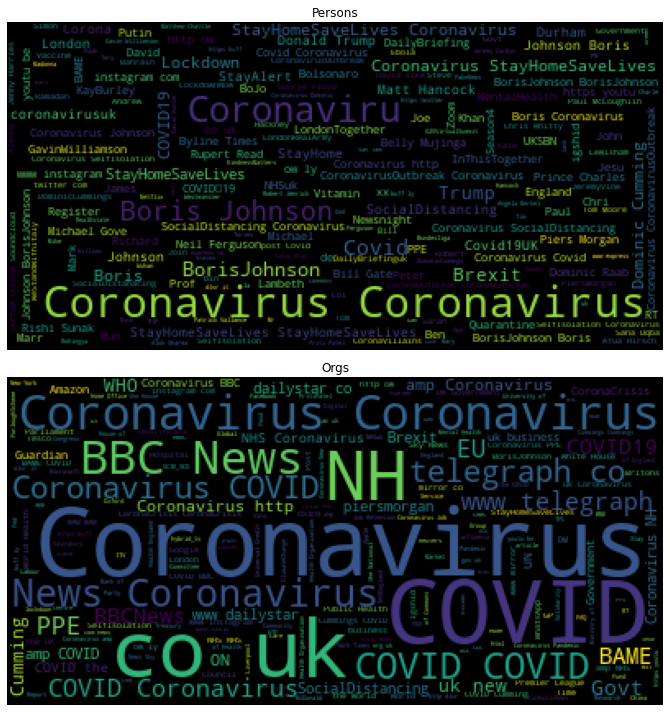

In [20]:
persons_text = " ".join(tweet for tweet in tweets.persons.dropna())
orgs_text = " ".join(tweet for tweet in tweets.orgs.dropna())

stopwords = set(STOPWORDS)
stopwords.update(['http', 'https', 'www', 'amp', 'ly', 'bit', 'coronavirus', 'Coronavirus', 'COVID', 'gt'])

persons_wordcloud = WordCloud(stopwords=stopwords).generate(persons_text)
orgs_wordcloud = WordCloud(stopwords=stopwords).generate(orgs_text)

fig, ax = plt.subplots(nrows=2, figsize=(10,10))
ax[0].imshow(persons_wordcloud)
ax[0].set_title('Persons')
ax[0].axis('off')
ax[1].imshow(orgs_wordcloud)
ax[1].set_title('Orgs')
ax[1].axis('off')
plt.tight_layout();

Which persons / orgs were the winners and losers in terms of sentiment?
- like above, we will filter for those entities only appearing in emotive tweets

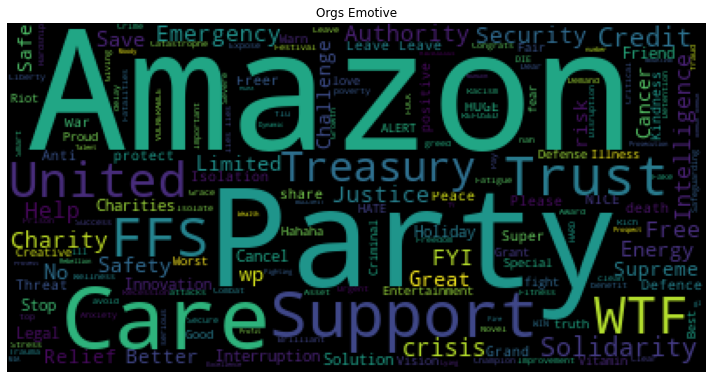

In [14]:
persons_text_df, persons_sentiment = emotive_filter(persons_text)
orgs_text_df, orgs_sentiment = emotive_filter(orgs_text)

persons_emotive_words = persons_text_df[(persons_sentiment.compound < -0.05) | (persons_sentiment.compound > 0.05)]
orgs_emotive_words = orgs_text_df[(orgs_sentiment.compound < -0.05) | (orgs_sentiment.compound > 0.05)]

persons_emotive_wordcloud = WordCloud(stopwords=stopwords).generate(persons_emotive_words.to_string())
orgs_emotive_wordcloud = WordCloud(stopwords=stopwords).generate(orgs_emotive_words.to_string())

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(orgs_emotive_wordcloud)
ax.set_title('Orgs Emotive')
ax.axis('off')
plt.tight_layout()
fig.savefig('./images/wordcloud_wnl_emotive.png');

... well, that got very blue very quickly, but aside from that...
Spacy's entity recognizer appears to confuse any word capitalised with an entity. Which makes it difficult to get a clear picture this way of winners and losers, although we can see Amazon and Treasury come to the surface, which inspires the next Hypothesis...

#### Hypothesis 4:
Amazon will be a big winner due to consumers switching to online shopping during the lockdown.
For this I will need to confirm 2 things:
1. Amazon sentiment was positively impacted by the lockdown, vs. it's pre-lockdown average

In [21]:
lockdown = datetime.strptime('2020-03-16', '%Y-%m-%d').date()

amazon_prelockdown = tweets[(tweets.orgs=='Amazon') & (tweets.date.dt.date < lockdown)][['orgs','date','compound','text']]
amazon_postlockdown = tweets[(tweets.orgs=='Amazon') & (tweets.date.dt.date >= lockdown)][['orgs','date','compound','text']]

In [237]:
stats.ttest_ind(amazon_prelockdown.compound, amazon_postlockdown.compound)

Ttest_indResult(statistic=0.10878616367025529, pvalue=0.9134795533240211)

We cannot reject null due to a high p-value, let's assess the Statistical Power of our test, we need to assess how many samples we had for each side of the test, to then ascertain if the standard error was low enough to give the test good statistical power:

In [194]:
print('Number of pre_lockdown Amazon tweets =', len(amazon_prelockdown))
print('Number of post_lockdown Amazon tweets =', len(amazon_postlockdown))

Number of pre_lockdown Amazon tweets = 3
Number of post_lockdown Amazon tweets = 201


This highlights the issue, only 3 pre-lockdown tweets in our dataset, so the standard error of the pre-lockdown distribution was too high to enable a good statistical test. Let's test this another way...

2. Amazon sentiment in lockdown period was higher than the average across all other entities

In [22]:
lockdown = datetime.strptime('2020-03-16', '%Y-%m-%d').date()

amazon_postlockdown = tweets[(tweets.orgs=='Amazon') & (tweets.date.dt.date > lockdown)][['orgs','date','compound','text','username']]
others_postlockdown = tweets[(tweets.orgs!='Amazon') & (tweets.date.dt.date > lockdown)][['orgs','date','compound','text','username']].dropna()

We need to check the default assumption that equal_var = True in scipy's ttest_ind(), by checking that the standard deviations of each distribution is roughly the same:

In [239]:
print('Amazon std', np.std(amazon_postlockdown.compound))
print('Other entities std', np.std(others_postlockdown.compound))

Amazon std 0.48048419059058534
Other entities std 0.5026733516055498


... confirms equal_var = True ... and therefore we can adopt a pooled variance approach

In [240]:
stats.ttest_ind(amazon_postlockdown.compound, others_postlockdown.compound)

Ttest_indResult(statistic=2.469890113757005, pvalue=0.01351783280956628)

We have a low p-value which would lead us to reject the null, however let's check the distributions and the sample sizes to check that the assumption of normality holds, for us to have performed this parametric statistical test:

Amazon sample size 243
Other entities sample size 94912


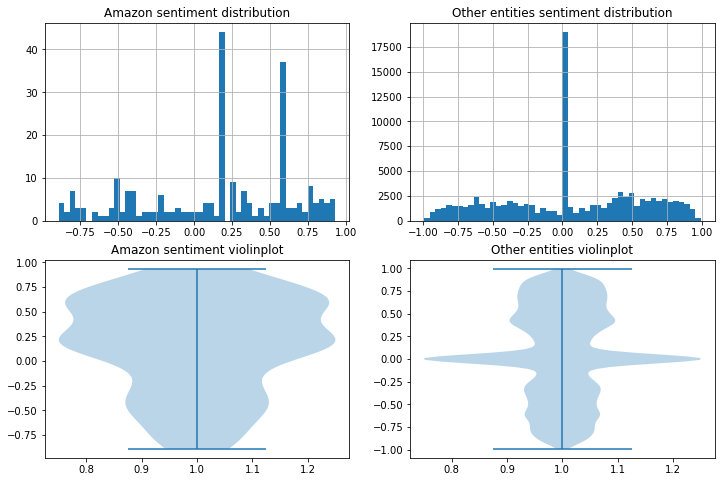

In [16]:
print('Amazon sample size', len(amazon_postlockdown))
print('Other entities sample size', len(others_postlockdown))
fig, ax = plt.subplots(2, 2, figsize=(12,8))
ax = ax.ravel()
amazon_postlockdown.compound.hist(bins=50, ax=ax[0])
ax[0].set_title('Amazon sentiment distribution')
others_postlockdown.compound.hist(bins=50, ax=ax[1])
ax[1].set_title('Other entities sentiment distribution')
ax[2].violinplot(amazon_postlockdown.compound)
ax[2].set_title('Amazon sentiment violinplot')
ax[3].violinplot(others_postlockdown.compound)
ax[3].set_title('Other entities violinplot')
fig.savefig('./images/amazonvrest_ditributions.png');

- Although we have 201 Amazon-related tweets, which would normally mean we can rely on the CLT, the non-normal distribution means I want to check the robustness of my inference to the normality / CLT assumption.
- To do this, I will conduct the non-parametric analogue of the 2-iid-sample t-test, called the Mann-Whitney test, which compares the medians of each distribution rather than the mean

In [228]:
stats.mannwhitneyu(amazon_postlockdown.compound, others_postlockdown.compound, alternative='greater')

MannwhitneyuResult(statistic=7790158.5, pvalue=0.0022638683822703305)

... which, confirms that our verdict is robust to the normality assumption.
- The other issue with this is the incredibly large sample size for 'Other Entities' (which is a simple if orgs != 'Amazon' filter), which means it resembles an unfiltered dataset centered on 0 valence.
- To counteract this, I will need to manually construct a list of tweeted-about non-Amazon entities which will be the population I include in Other Entities.
- These are the most tweeted-about orgs in our dataset:

In [287]:
others_postlockdown.groupby('orgs').count().sort_values('compound',ascending=False).head()

,date,compound,text
orgs,,,
Premier League,105,105,105
Google,101,101,101
Tesco,101,101,101
Apple,78,78,78
Facebook,64,64,64


Many of these are clearly either incorrectly assigned as ORGS by spacy, or media outlets originating the tweets so I will omit these, those that remain as candidates for inclusion in 'Other Entities' category are:
- WHO, Facebook, FDA, UN, Whatsapp, Tesco, Premier League, Google, FDA, Apple, CDC, Parliament, White House

I will compare Amazon only with commercial enterprises, and not governmental / supranational bodies...

In [23]:
other_entities = ['Facebook', 'Whatsapp', 'Tesco', 'Premier League', 'Google', 'Apple']
others_postlockdown = tweets[(tweets.orgs.isin(other_entities)) & (tweets.date.dt.date > lockdown)][['orgs','date','compound','text']].dropna()

Something odd about the Amazon distribution are the 'twin peaks', there seems to be two clusters of similarly-valenced tweets.
- At compound_score = 0.5994, there were 35 tweets with the same text, part of a campaign, these should be omitted (in fact dropping duplicate tweets is something that is wise for all subsamples I will be testing). Interestingly too, Amazon here is in the context of the rainforest, an issue exacerbated by the viral nature of this tweet. I will allow the drop_duplicates() to take care of that for me.
- At compound_score = 0.1779, there were 37 tweets referencing the correct Amazon entity and the virus, these are not duplicated so I will not omit them

In [300]:
amazon_postlockdown[amazon_postlockdown.compound==0.5994].head()

,orgs,date,compound,text,username
271864,Amazon,2020-05-03 11:26:32+00:00,0.5994,‘We are on the eve of a genocide’: Brazil urged to save Amazon tribes from Covid-19,guardianworld
271951,Amazon,2020-05-03 11:33:19+00:00,0.5994,‘We are on the eve of a genocide’: Brazil urged to save Amazon tribes from Covid-19,guardian
272191,Amazon,2020-05-03 11:57:50+00:00,0.5994,‘We are on the eve of a genocide’: Brazil urged to save Amazon tribes from Covid-19,ianderry
272713,Amazon,2020-05-03 12:51:07+00:00,0.5994,‘We are on the eve of a genocide’: Brazil urged to save Amazon tribes from Covid-19,cacalulondon
273238,Amazon,2020-05-03 13:44:59+00:00,0.5994,‘We are on the eve of a genocide’: Brazil urged to save Amazon tribes from Covid-19,StephenJRusse1l


In [299]:
amazon_postlockdown[amazon_postlockdown.compound==0.1779].head()

,orgs,date,compound,text,username
40951,Amazon,2020-03-18 18:53:17+00:00,0.1779,Amazon Will Cease Stocking Vinyl Records Due to Coronavirus https://consequenceofsound.net/2020/03/amazon-vinyl-coronavirus/ via @alexyoung,SM_Sounds
71527,Amazon,2020-03-22 07:58:15+00:00,0.1779,Il #Coronavirus AZZOPPA #Amazon: consegna solo beni di prima necessità. E invece i supermercati fisici volano alla grande,EnricoVerga
104300,Amazon,2020-03-25 23:11:11+00:00,0.1779,#goodnews2020 The finger-prick #coronavirus home-tests antibody will be available in #UK on 'coming days' in Boots and Amazon.,YasinRasoul
108235,Amazon,2020-03-26 13:38:32+00:00,0.1779,Here is a thought why don’t the supermarkets team up with Amazon so they can use their deliver system to increase their capacity to provide home deliver to larger number of people just saying national emergency #StayHomeSaveLives #FoodSupply #coronavirus #workingtogether,thehousingecon
108861,Amazon,2020-03-26 14:55:30+00:00,0.1779,I’m assuming the crates have already been made up or if not they are detoxing every bottle with a spray. Amazon? There are covid cases in the states in the warehouses,MsMarmitelover


In [24]:
amazon_postlockdown.drop_duplicates(subset='text', inplace=True)
others_postlockdown.drop_duplicates(subset='text', inplace=True)

Check on sample sizes and distributions

Amazon sample size 183
Other entities sample size 520


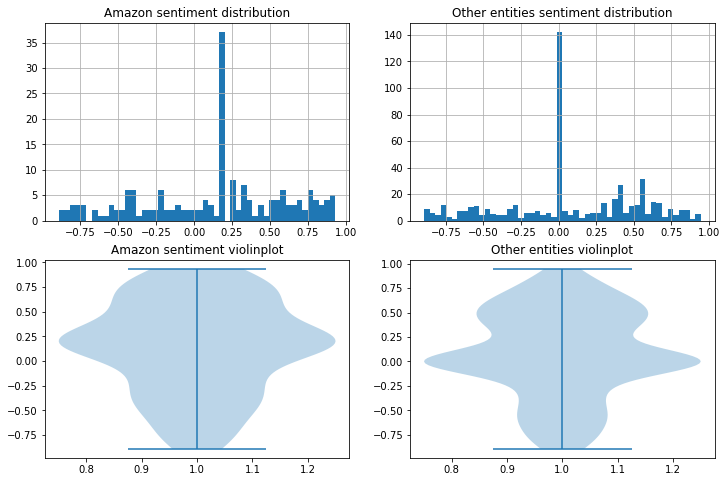

In [19]:
print('Amazon sample size', len(amazon_postlockdown))
print('Other entities sample size', len(others_postlockdown))
fig, ax = plt.subplots(2, 2, figsize=(12,8))
ax = ax.ravel()
amazon_postlockdown.compound.hist(bins=50, ax=ax[0])
ax[0].set_title('Amazon sentiment distribution')
others_postlockdown.compound.hist(bins=50, ax=ax[1])
ax[1].set_title('Other entities sentiment distribution')
ax[2].violinplot(amazon_postlockdown.compound)
ax[2].set_title('Amazon sentiment violinplot')
ax[3].violinplot(others_postlockdown.compound)
ax[3].set_title('Other entities violinplot')
fig.savefig('./images/amazonvrest_ditributions_cleaned.png');

In [326]:
print('Amazon std', np.std(amazon_postlockdown.compound))
print('Other entities std', np.std(others_postlockdown.compound))

Amazon std 0.4649397891561304
Other entities std 0.4376061245098044


In [311]:
stats.ttest_ind(amazon_postlockdown.compound, others_postlockdown.compound)

Ttest_indResult(statistic=1.1270992972809608, pvalue=0.26018755847340846)

Having now:
- removed duplicated tweets, ie. ensured proper random sampling rather than my data being susceptible to clustering.
- restricted the Other Entities to just commercial entities

We now fail to reject the null because:
- removing the duplicates saw the removal of the 35 tweets and a reduction in Amazon's mean score from 0.15 to 0.11
- although standard deviation of other_entities was little changed, restricting Other Entities saw a drop in standard error from 0.0019 to 0.02, due to a large drop in sample size, therefore reducing the statistical power of the test.

In essence, if we wanted to be sure that Amazon's positive mean was statistically significant, we would need to collect more samples to increase the power of our test to reject the null (and also obviously hope this doesn't alter the means too much)

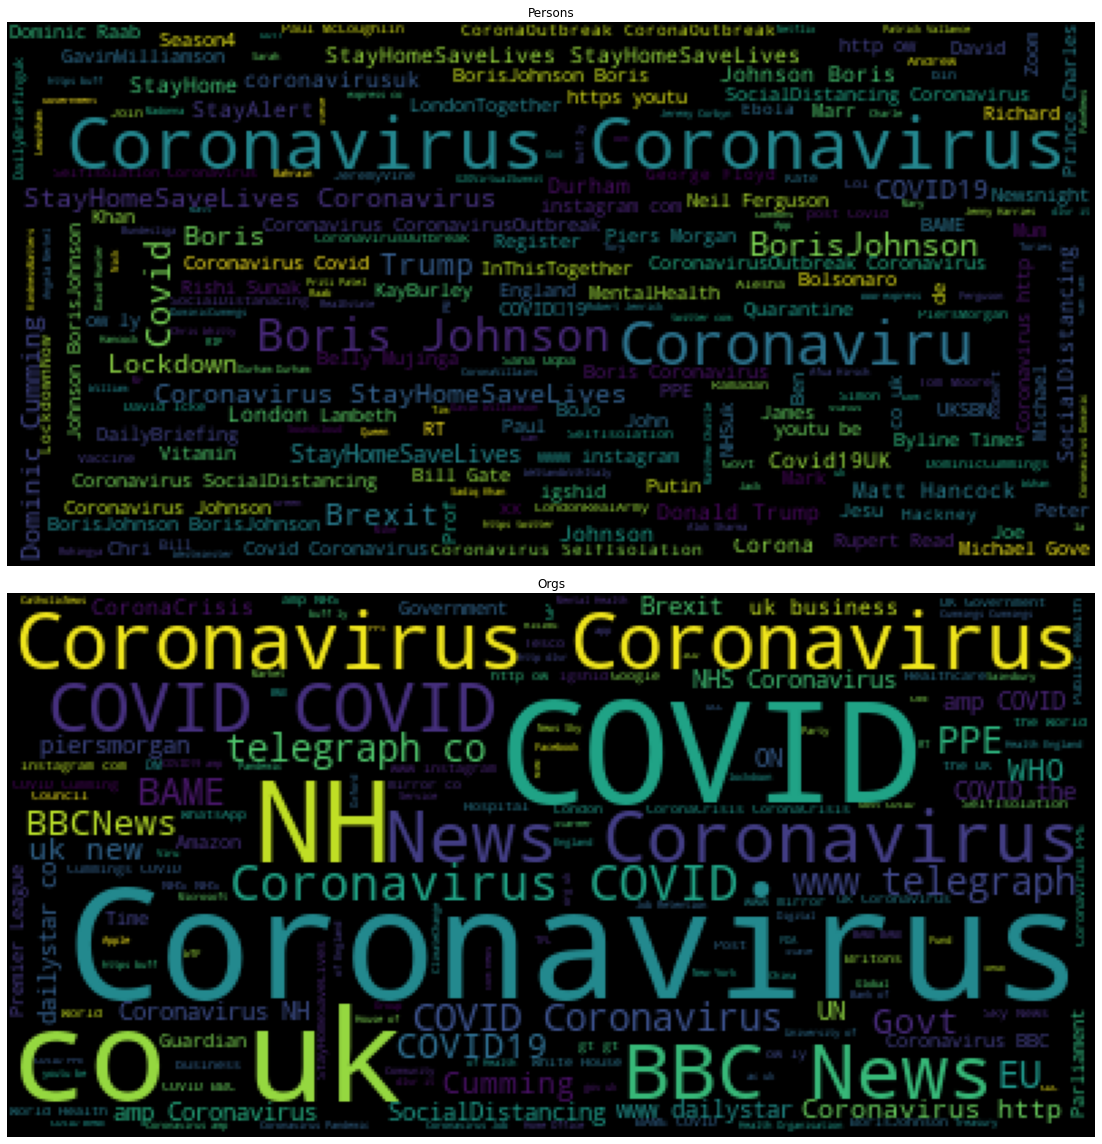

In [25]:
persons_text = " ".join(tweet for tweet in tweets.persons.dropna())
orgs_text = " ".join(tweet for tweet in tweets.orgs.dropna())

stopwords = set(STOPWORDS)
stopwords.update(['http', 'https', 'www', 'amp', 'ly', 'bit', 'coronavirus', 'Coronavirus', 'COVID'])

persons_wordcloud = WordCloud(stopwords=stopwords).generate(persons_text)
orgs_wordcloud = WordCloud(stopwords=stopwords).generate(orgs_text)

fig, ax = plt.subplots(nrows=2, figsize=(16,16))
ax[0].imshow(persons_wordcloud)
ax[0].set_title('Persons')
ax[0].axis('off')
ax[1].imshow(orgs_wordcloud)
ax[1].set_title('Orgs')
ax[1].axis('off')
plt.tight_layout();

#### Verdict
1. Null Hypothesis: Amazon sentiment was the same pre- and post-lockdown: failed to reject null. Not enough data for the pre-lockdown period.
2. Null Hypothesis: Amazon sentiment was same as other entities post-lockdown: failed to reject null, as p-value = 0.26 which is within the realms of statistical possibility accounting for sampling variation if the null hypothesis is true

#### Power Analysis
- We were unable to reject the null in the 2nd hypothesis above due to low power in the test. We conduct a Power Analysis to see how large the sample size should be to give us 95% confidence that the difference between the means is statistically significant.

- Power = 0.8, ie. let's say we want a 80% chance of correctly rejecting the null
- Significance threshold = 0.05


- We are estimating the overlap between the two distributions, which is affected by difference between means and also the spread of each distribution, this is calculated here using Effect Size, d $ = \frac{difference in means}{pooled std dev}$
    - where: pooled standard deviation = ${\sqrt{\frac{s_1^2 + s_2^2}{2}}}$

In [20]:
diff_means = (np.mean(amazon_postlockdown.compound) - np.mean(others_postlockdown.compound))
pooled_std = np.sqrt((np.std(amazon_postlockdown.compound)**2 + np.std(amazon_postlockdown.compound)**2) / 2)
effect_size =  diff_means / pooled_std
effect_size

0.12764678397792467

In [21]:
tt_ind_solve_power(effect_size, len(amazon_postlockdown), 0.05, ratio=len(others_postlockdown)/len(amazon_postlockdown))

0.31700938670234596

Only a power of 20%, ie. only 20% of the time will we be able to correctly reject the null hypothesis. How big should sample size be to give us a desired power of 80%?

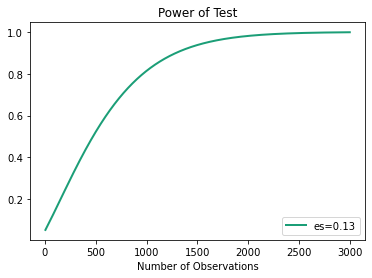

In [27]:
diff_means = (np.mean(amazon_postlockdown.compound) - np.mean(others_postlockdown.compound))
pooled_std = np.sqrt((np.std(amazon_postlockdown.compound)**2 + np.std(amazon_postlockdown.compound)**2) / 2)
effect_size = [diff_means / pooled_std]

nobs = np.array(range(5, 3000))

analysis = TTestIndPower()
analysis.plot_power(nobs=nobs, effect_size=effect_size)
plt.savefig('./images/poweranalysis.png');

- As our effect size is about 0.1, we would need a sample size of ~1500 in total to achieve a power of 80% in being able to confidently reject the null re: Amazon's better-than-average sentiment rating.
- This is because the distributions overlap considerably, and therefore we need a larger sample size to reduce the standard error per distribution sufficiently.
- So, even the commercial entity that had a relatively large number of tweets (Amazon) tested vs. ALL the other most tweeted about commerical entities doesn't give us enough statistical power to differentiate between their means. Even this most advantageous (ie, highest sample size) test still doesn't have a high enough effect size. Although we know from this 1-sample test (below) that we're confident that sentiment towards Amazon was positive.

In [116]:
stats.ttest_1samp(amazon_postlockdown.compound, 0)

Ttest_1sampResult(statistic=4.298040028883434, pvalue=2.616546144158821e-05)

So 2 sample tests don't have enough statistical power, whereas looking at each entity alone can, how do we then present this data across all entities to see which ones were indeed the winners / losers, without having to run a ttest for each entity manually...

### Modelling
- I will attempt to use ML classifiers to understand the impact of usage of each entity, e.g. Amazon, on whether a tweet is likely to be positive or negative.
- The idea is that I will be able to holistically compare overall winners and losers in the lockdown period.

#### Frequentist Approach
- Note: the Logistic Regression is labelled a Frequentist approach because it looks at only observed data, without any prior assumptions. This could be sufficient for our purposes as we're only interested in the post-lockdown period and only for those entities which had sufficient pos / neg tweets to be names 'winner' or 'loser', ie. sample size is large enough here.

In [28]:
lockdown = datetime.strptime('2020-03-16', '%Y-%m-%d').date()

logit_df = tweets[tweets.date.dt.date >= lockdown][['orgs','compound','text']].drop_duplicates('text').dropna()
logit_df['label'] = logit_df.apply(lambda x: 'POS' if x['compound']>0.05 else ('NEG' if x['compound']<-0.05 else 'NEU'), axis=1)
logit_df = logit_df[logit_df.label!='NEU']

le = LabelEncoder()
y = le.fit_transform(logit_df.label)

stopwords = set(STOPWORDS)
stopwords.update(['http', 'https', 'www', 'amp', 'ly', 'bit', 'com', 'co', 'uk', 'dm', 'bbc', 'bbcnews',
                  'coronacrisis', 'coronavirus', 'govt', 'england', 'home', 'house', 'national', 'news', 
                  'parliament', 'piersmorgan', 'sky', 'times', 'premier', 'us', 'nightingale', 'new',
                  'igshid', 'healthcare', 'business', 'bank', 'british', 'oxford', 'labour', 'bame', 'council',
                  'imperial', 'mirror', 'royal', 'rt', 'gt', 'college', 'tesco', 'white', 'ffs', 'cnn',
                  'department', 'dailystar', 'gp', 'icu', 'international', 'ministry', 'state', 'technology',
                  'wtf', 'org', 'ow', 'centre', 'ac', 'article', 'britons', 'european', 'financial', 'food',
                  'institute', 'lt', 'virus', 'telegraph', 'school', 'people', 'mental', 'cabinet', 'lockdown'])
tvec = TfidfVectorizer(stop_words=stopwords, token_pattern='[A-Za-z]{2,}', max_features=70)
X = tvec.fit_transform(logit_df.orgs).toarray()
X = pd.DataFrame(X, columns=tvec.get_feature_names())

log_model = sm.Logit(y, X)
log_results = log_model.fit(maxiter=500)
print(log_results.summary())
print(log_results.summary(), file=open('./images/OLS.txt', 'a'))

/Users/Noah/anaconda3/envs/nlp_architect/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Optimization terminated successfully.
         Current function value: 0.680980
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                71886
Model:                          Logit   Df Residuals:                    71816
Method:                           MLE   Df Model:                           69
Date:                Wed, 24 Jun 2020   Pseudo R-squ.:                0.007740
Time:                        08:39:31   Log-Likelihood:                -48953.
converged:                       True   LL-Null:                       -49335.
Covariance Type:            nonrobust   LLR p-value:                9.979e-118
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
amazon                0.8422      0.141      5.965      0.000       0.565       1.119
app     

(Note: I manually added to the list of stopwords, words that were polluting the Logit Regression results)

- Winners:
    - Tech companies. A positive coefficient, and a p-value close to 0 for that coefficent leaves us in no doubt that companies like Amazon, Apple, Whatsapp, Instagram were percieved positively by tweeters. Except for Twitter iteslf, which had wide variability in sentiment.
    - stayhomesavelives, the UK Government's slogan, also had a very positive coefficient. Along these lines selfisolation was another positive story, and socialdistancing. It appears the public took on board these efforts positively.
- Losers:
    - Dominic Cummings. The polarising figure had a very negative coefficient, with a high degree of confidence looking at the p-value. Likely due to the controversy surrounding his decision to break social-distancing rules.
    - Keir Starmer surprisingly has a negative coefficient, could this be due to criticisms of the govt approach? No, it's due to people's criticism that he didn't hold the government to account strongly enough.
    - ppe was also negatively portrayed, probably owing to the shortages being seen in NHS hospitals.
- Other notes:
    - Words describing government figures and the departments, generally had a high p-value, and wide CIs crossing the 0 threshold. Indicating mixed views from the public on their performance?

#### Bayesian Approach
##### Frequentist to Bayesian...
- So far I have been taking a frequentist approach to testing my hypotheses about sentiment towards various entities, which broadly means:
    - There's an assumption that there is one number (a constant): the population mean
$\mu$
    - We come to a new assumption if our null hypothesis is disproved by observations.
    - We view our data as random samples from that population which gives an estimate for
$\mu$ (called 
$\bar{x}$
)
- Now we will look at a Bayesian approach, which says:
    - The data is not a random sample from a broader population (an assumption which therefore requires us to look at sampling statistics), but that the data IS the data and is fixed. We have no knowledge of another 'population'.
    - The 
$\mu$ however is not a constant but is a DISTRIBUTION of probable values: a probability distribution 
$p$
    - This distribution is updated using Bayesian updating, where we multiply by Likelihood function, which represents new data
$P(data \;|\; p)$
    - This output
$P(p \;|\; data)$ is a prior assumption updated with current observations, and is a distribution for our predictions, which highlights our certainty of that relationship.
$$ P(p \;|\; data) = \frac{ P(data \;|\; p) }{ P(data) } P(p) $$

Given the 'live' nature of my data collection, and how sentiment towards an entity will have evolved over time, it makes sense to look at Bayesian techniques.

##### Bayesian Approach: the details
1. We have the general formula for Bayesian modelling:
$$ P(p \;|\; data) \propto P(data \;|\; p)  P(p) $$

2. Broadly, we have 2 options for modelling the probability distributions:
    - Conjugacy (simpler / preferred if you can achieve this): The posterior distribution $P(p \;|\; data)$ is guaranteed to be of the same form as the prior distribution $P(p)$ when the prior distribution is a conjugate prior to the likelihood function $P(data \;|\; p)$. This would make the Bayesian updating algebraically solvable, and therefore parameters for the posterior can be expressed in terms of paramaters of the prior and likelihood.
    - Sampling techniques, e.g. Markov Chain Monte Carlo: There are a finite number of conjugate priors, if our data doesn't fit any of these, then we'd need to use sampling techniques.

3. Let's look at our particular case:
    - We have a binary outcome: either a Positive or a Negative tweet (Note - I'm only interested in polarising tweets and will exclude those scored as Neutral).
    - So luckily for this simple case, we have conjugate priors that we can use.
$$ P(p \;|\; n,k) \propto P(n,k \;|\; p) \cdot P(p) $$

4. Binary outcome: Conjugacy.
    - Likelihood:
        - The sampling we will see is a stream of tweets that are either Positive or Negative. This is represented by a Binomial distribution.
$$\binom{n}{k} p^k (1 - p)^{n-k}$$
    - Prior:
        - The Beta distribution is what best describes a distribution of probabilities for 2 binary outcomes
        - We also use this as it's also the known conjugate prior to the Binomial distribution.
$$\frac{\Gamma (\alpha + \beta) }{ \Gamma (\alpha) \Gamma (\beta) }p^{\alpha-1}(1-p)^{\beta-1} $$
    - Posterior: update as here:
$$ 
P(p \;|\; n,k) 
\propto
\binom{n}{k} p^k (1 - p)^{n-k} \cdot \frac{\Gamma (\alpha_{\rm prior} + \beta_{\rm prior}) }{ \Gamma (\alpha_{\rm prior}) \Gamma (\beta_{\rm prior}) }p^{\alpha_{\rm prior}-1}(1-p)^{\beta_{\rm prior}-1}
$$
<font color = red>
    - You can clearly see here that the Binomial distribution is the discrete random variable form for the continuous Beta distribution random variable, which nicely mimics what is happening: as the new data comes in, we represent this a discrete data points in the Binomial, that will update an overall prior belief that is continuous.
</font>
    - Because of this you can easily foresee that the exponents will collapse down to give a posterior belief that's also a Beta distribution just adjusted by the $(n, k)$ from the Binomial:
$$ P(p|n,k)=
\frac{\Gamma(n+\alpha_{\rm prior}+\beta_{\rm prior})}{\Gamma(k+\alpha_{\rm prior})\Gamma(n-k+\beta_{\rm prior})}
p^{k+\alpha_{\rm prior}-1}(1-p)^{n-k+\beta_{\rm prior}-1}
$$

    - hence, we can simply algebraically solve for the posterior parameters:

$$ \begin{aligned}
\alpha_{\rm posterior} &=  k+\alpha_{\rm prior} \\
\beta_{\rm posterior} &= n-k+\beta_{\rm prior}
\end{aligned} $$

##### Test case for Bayesian Approach: Amazon

In [26]:
lockdown = datetime.strptime('2020-03-16', '%Y-%m-%d').date()
bayes = tweets.copy()
bayes['label'] = bayes['compound'].apply(labeller)
bayes = bayes[bayes.label != 'NEU']
bayes.drop_duplicates(subset='text', inplace=True)

amazon_prior = bayes[(bayes.orgs=='Amazon') & (bayes.date.dt.date < lockdown)]

In [28]:
print('Prior\n', amazon_prior.label.value_counts(), '\n')
print('Posterior\n', amazon_posterior.label.value_counts(), '\n\nNo. Trials\n', amazon_posterior.label.count())

Prior
 POS    2
NEG    1
Name: label, dtype: int64 

Posterior
 POS    109
NEG     54
Name: label, dtype: int64 

No. Trials
 163


- Before the lockdown started, there were 3 POS or NEG Amazon-related tweets, and 2 of them were POS.
This represents a weak prior belief of sentiment towards Amazon.
- By the end, we had 106 POS and 54 NEG, this progression can be visualised by simply plotting the distributions with the parameters we solved for above, here:

- The Maximum a Posteriori estimation (MAP) hasn't changed vs. our prior belief, however we're more sure of it than our prior belief due to narrow peak from having collected more data samples.

##### Generalizing the approach beyond the test-case:
- Now that we see the test-case works, we generalize this model to be applicable to different entities of interest.
- I will be creating an animation that shows the daily progress of the posterior distribution for that entity, which will highlight to us any trends / specific timeframes of interest

In [4]:
def org_stats_calculator(org=None, df=tweets):
    '''Create stats on positive / negative tweets for chosen org, will be used later in Bayesian Updating'''
    
    bayes = df.copy()
    bayes['label'] = bayes['compound'].apply(labeller)
    bayes = bayes[bayes.label!='NEU']
    bayes.drop_duplicates(subset='text', inplace=True)

    date_range = bayes.date.dt.date.unique()
    num_records = np.sum(bayes.orgs=='{}'.format(org))
    
    pos = np.array([])
    neg = np.array([])
        
    if org != None:
        if num_records != 0:
            print("{} records found for '{}' in dataset".format(num_records, org))
            for date in tqdm(date_range):
                try:
                    pos = np.append(pos, bayes[(bayes.orgs=='{}'.format(org)) & (bayes.date.dt.date==date)] \
                                     .label.value_counts().POS)
                except AttributeError:
                    pos = np.append(pos, 0)

                try:
                    neg = np.append(neg, bayes[(bayes.orgs=='{}'.format(org)) & (bayes.date.dt.date==date)] \
                                     .label.value_counts().NEG)
                except AttributeError:
                    neg = np.append(neg, 0)
        else:
            print("{} records found for '{}' in dataset. Exiting...".format(num_records, org))
            pass
    else:
        for date in tqdm(date_range):
            pos = np.append(pos, bayes[(bayes.orgs=='{}'.format(org)) & (bayes.date.dt.date==date)] \
                                 .label.value_counts().POS)
            neg = np.append(neg, bayes[(bayes.orgs=='{}'.format(org)) & (bayes.date.dt.date==date)] \
                                 .label.value_counts().NEG)
            
    return date_range, pos, neg

In [5]:
def bayes_prior_calculator(dt_array, pos_cnt_array, neg_cnt_array, dt_post='2020-03-16'):
    '''Calculate Bayesian Prior Distribution stats'''

    dt_lockdown = datetime.strptime('{}'.format(dt_post), '%Y-%m-%d').date()
    successes_prior = np.sum(pos_cnt_array[dt_array <= dt_lockdown])
    failures_prior = np.sum(neg_cnt_array[dt_array <= dt_lockdown])

    if successes_prior > 0:
        alpha = successes_prior + 1
    else:
        alpha = 0.5
    if failures_prior > 0:
        beta = successes_prior + 1
    else:
        beta = 0.5

    dates_posterior = dt_array[dt_array >= dt_lockdown]

    return dates_posterior, dt_lockdown, alpha, beta

In [6]:
def bayesian_animator(org):
    date_range, pos, neg = org_stats_calculator('{}'.format(org))
    dates_posterior, dt_lockdown, alpha, beta = bayes_prior_calculator(date_range, pos, neg, '2020-03-16')

    play = widgets.Play(
       interval=200,
       value=0,
       min=0,
       max=len(dates_posterior)-1,
       step=1,
       description="Press play",
       disabled=False
    )

    slider = widgets.IntSlider(
        value=0,
        min=0,
        max=len(dates_posterior)-1,
        step=1
    )

    widgets.jslink((play, 'value'), (slider, 'value'))
    ui = widgets.HBox([play])


    def f(slider):    
        date_in_lockdownperiod = dates_posterior[slider]

        n = np.sum(pos[(date_range > dt_lockdown) & (date_range <= date_in_lockdownperiod)]) \
                + np.sum(neg[(date_range > dt_lockdown) & (date_range <= date_in_lockdownperiod)])
        k = np.sum(pos[(date_range > dt_lockdown) & (date_range <= date_in_lockdownperiod)])

        # instantiate the prior beta distribution with shape parameters alpha, beta
        beta_prior = stats.beta(alpha, beta)
        # instantiate the posterior beta distribution with shape parameters shifted by n and k
        beta_posterior = stats.beta(alpha+k, beta+n-k)

        # set up x and y-values for plotting
        pvals = np.linspace(0., 1., 100)
        prior = beta_prior.pdf(pvals)
        posterior = beta_posterior.pdf(pvals)

        fig, ax = plt.subplots()
        ax.plot(pvals, posterior, lw=3,
            label='Posterior Beta PDF for\n'+r'$\alpha+k={}$, $\beta+n-k={}$'.format(
                alpha+k, beta+n-k)
            )
        ax.plot(pvals, prior, lw=3,
            label='Prior Beta PDF for\n'+r'$\alpha={}$, $\beta={}$'.format(
                alpha, beta)
            )
        ax.set_xlabel('p')
        ax.set_ylabel(r'Pdf(p | $\alpha$, $\beta$)')
        ax.set_title('Posterior and prior Beta PDF')
        plt.legend(loc='upper left')
        plt.show()
        return

    display(ui)

    interact(f,slider=slider);

In [7]:
bayesian_animator('Amazon')

183 records found for 'Amazon' in dataset


interactive(children=(IntSlider(value=0, description='slider', max=78), Output()), _dom_classes=('widget-inter…

### Lockdown: The Winners and Losers
- __Amazon__: as we mentioned, it started off in neutral territory: 0.5. But jumped into positive territory almost immediately after the lockdown, and stayed.
- __Cummings__: Very interesting to see, e.g. you can run this for Cummings and see how his stock has fallen over the lockdown period. This had already started by a week into the lockdown, which perhaps shows the prior belief (informed by tweets prior to lockdown) was not in line with what we would come to later understand of public feeling towards him. In the last few days, with the story that he broke the lockdown, the posterior makes a dramatic shift to the left, crossing over into <0.5 territory and rapidly becoming peaked at ~0.4
- __SocialDistancing__: Very quickly became positive, and stayed positive, showing the focused mood of a nation.
- __Government__: no prior belief about views on the Government, however after immediately seeing positive sentiment in the lockdown period, we started to see that normalise back towards 0.5 and settling just above that level. Mixed views here, started strong but faded.
- __Keir Starmer__: has been a big Loser from the Coronavirus period, with many Labour supporters unhappy at his support of the government's approach, and of course those on Conservative side bound to be against him.

## Conclusion

- __In conclusion__, we showed that it's possible to set up a feed in from Twitter, apply some text processing, conduct sentiment scoring, and analyse the per-entity sentiment, in a way that clarifies the winners / losers.
- __Hypothesis Testing__: used this extensively to understand bring some statistical clarity to my findings, which taught me a few areas to be cautious about:
    - __p-values__: can be easily made to be statistically significant if the sample size if large enough to ensure a low enough standard error, ask yourself if your test is specific enough to ask a pointed question? Ask yourself if your filtering is set up correctly, ensuring your sample isn't inflated.
    - __normality assumption__: this generally held in most cases, thanks to the Central Limit Theorem, but we can always use non-parametric versions of our hypothesis tests like Mann-Whitney or Wilcoxon Signed-Rank tests.
    - __mean reversion / neutralisation__: for any slice of the data that's large enough / not specific enough, sentiment would generally cluster around 0 and not be meaningful. View the distribution of your subsample, and if it has a high peak at 0 sentiment then likely you need to be more specific with filtering for a meaningful hypothesis test.
- __Holistic Winners/Losers__: To get an overall view, I used Logistic Regression to model positive vs negative labelled tweets, using the vectorized entity column as the predictor matrix. This gave some interesting results:
    - The overall $R^2$ was low, suggesting I needed more features than the few I included to be able to model accurately whether a tweet would be positive or negative.
    - However, this wasn't what I wanted... I was interested in how those features I did include contribute to positivity or negativity, which I could get from their coefficients. The nice things about using the Statsmodel package vs sklearn's was being able to see the statistical confidence of each coefficient.
    - So because we actually want to solve for $P(p \;|\; data)$ not $P(data \;|\; p)$, and also because we have a constantly evolving view of $P(p \;|\; data)$ we want to follow, we turned to Bayesian approach:
- __Bayesian Winners/Losers__: Here I set up an animated slider to show the prior distribution, and then how the posterior distribution varied after that as new data came in, which could be configured to the entity of choice.
    - This showed clearly how/when Cummings and Starmer sentiment started to deteriorate, giving some good explanation.
    - It also clearly showed certainty of our posterior beliefs, by attaching a probability distribution to the sentiment at each stage.
    - The Beta-Binomial model was used which simplified the parameters greatly, a good way to view this conjugacy is that the binomial distribution is just the discrete version of the beta ditribution, and therefore simply reflects the addition of individual new data-points to the continuous prior. This is solved mathematically as the update of the beta parameter by addition of the binomial parameter.

## Future Enhancements

- This has hope of being modularized such that it's generalizable as a Twitter monitor, which has the below capabilities:
    - New tweets come in, they are post-processed using spacy and vader.
    - We are able to conduct some hypothesis tests on sections of the data.
    - We can provide a holistic view through Logistic Regression
    - We can view Bayesian Updating in an animation for a chosen entity.
- I also want to learn a bit more about spacy, and see if it's possible to train the Entity Recognizer better such that any capitalized word isn't mistaken for an entity